In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter



### Functions

In [2]:
def get_data(datafile):
    saltf = datafile.final_salt
    transpf = datafile.final_transp
    lonf = datafile.final_lon
    latf = datafile.final_lat
    depthf = datafile.final_depth
    sectionf = datafile.final_section
    zf = datafile.final_z
    tempf = datafile.final_temp
    
    return saltf,transpf,lonf,latf,depthf,sectionf,zf,tempf
    

In [3]:
#Function to extract data from 1 section

def splitsec(sectionfull,sectionnum,transport,longitude,depth,z,salt,temp):
    idx = np.where(sectionfull==sectionnum)
    transp_sec = transport[idx]
    lon_sec = longitude[idx]
    depth_sec = depth[idx]
    zf_sec = z[idx]
    salt_sec = salt[idx]
    temp_sec = temp[idx]
    return transp_sec,lon_sec,depth_sec, zf_sec,salt_sec,temp_sec

In [4]:
#Function that calculates the average m3/s (summing over hours and then dividing by hours that it was seeded for)

def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [5]:
#Calculates all properties for each section

def calculate_all(section, allv, folder, subfolder, lmax):
    final = {}
    mean = {}    
    filename = 'ariane_positions_quantitative.nc'
    fullfile = os.path.join('/ocean/cstang/MOAD/analysis-camryn/Ariane/', folder, subfolder, filename)
    try:
        if os.stat(fullfile).st_size > 0:
            filegood = True
            data = xr.open_dataset(fullfile)
            final_section = data.final_section
            final_transport = data.final_transp
            transport = np.sum(np.where(final_section == section, final_transport, 0)) 
            #transport= the sum of particles through this section (m3/s), same as stats.txt summary once divided by 24
            for variable in allv:
                #this loop calculates the mean values shown in stats.txt final state tables
                if variable == 'final_age':
                    scale = 86400. # convert from seconds to days
                    final[variable] = float('NaN')
                    mean[variable] = float('NaN')
                else:
                    if transport == 0:
                        final[variable] = float('NaN')
                        mean[variable] = float('NaN')
                    else:
                        scale = 1.
                        final[variable] = data.variables[variable][:]/scale
                        mean[variable] = np.sum(np.where(final_section == section, final_transport*final[variable], 0))/transport
        else:
            filegood = False
            transport = float('NaN')
            print ("empty file")
    except OSError:
        filegood = False
        transport = float('NaN')
        print ('Missing Data')
    return filegood, transport/lmax, mean 

#transport/lmax gives the section transport (same as .txt)
#mean is a dataframe of the average properties (for that section) of all the variables in allv

In [6]:
allv = ['final_temp','final_salt']
lmax = 168

folder = 'for_jan18'
subfolder = 'for_straight_01jan18_s7t28'

a1,a2,a3 = calculate_all(6,allv,folder,subfolder,lmax)

# data.final_temp

In [7]:
def get_data_all(start, endtime, section, allv, folder, subfolder, lmax): 
    #pretty sure the only difference between this and calculate_all is that this one seperates into days (susan wants me to do for whole month)
    timerange = arrow.Arrow.range('day', start, endtime)
    length = (endtime-start).days + 1
    transport = np.zeros(length)
    mean = {}
    for variable in allv:
        mean[variable] = np.zeros(length)
    time = []
    for i, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
#        print (dir1)
        filegood, transport[i], meanday = calculate_all(section, allv, folder, subfolder, lmax)
        for variable in allv:
            if filegood:
                mean[variable][i] = meanday[variable]
            else:
                mean[variable][i] = float('NaN')
        time.append(r.datetime)
    return transport[0], mean['final_salt'][0], mean['final_temp'][0]

In [8]:
#Requires f_lons, w_depths
#Plots 2 cross sections
#Need df 

def plotCS2(lonsec,zsec,transpsec,lonW,lonE,depi,title,lonsec2,zsec2,transpsec2,lonW2,lonE2,depi2,title2,straitname):
    
    cmap = cm.deep
    
    fig,ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.2]})
    
    arr,xe,ye,im = ax[0].hist2d(lonsec,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]),w_depths[0,0:depi]],density=True,
                                vmax=1
                                )
    
    ax[0].invert_yaxis()
    ax[0].set_title(title)
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Longitude (°E)')
    ax[0].set_xticks(np.linspace(f_lons[lonW],f_lons[lonE-1],4))
    ax[0].xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax[0].xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    
    arr2,xe2,ye2,im2 = ax[1].hist2d(lonsec2,df(zsec2)[0],weights=transpsec2,cmap=cmap,bins=[np.array(f_lons[lonW2:lonE2:1]),w_depths[0,0:depi2]],density=True,
                                    vmax=1
                                    )
    ax[1].invert_yaxis()
    ax[1].set_title(title2)
    ax[1].set_xlabel('Longitude (°E)')
    ax[1].set_yticklabels([])
    ax[1].set_xticks(np.linspace(f_lons[lonW2],f_lons[lonE2-1],4))
    ax[1].xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax[1].xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    cb2 = fig.colorbar(im2,ax=ax[1])    
    cb2.set_label('Transport (m/s)')
    
    fig.suptitle(straitname)
    

In [9]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,depi,vmax,time,title,cblabel,ylabel):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    # axv.set_xticklabels(np.round(np.linspace(f_lons[lonW],f_lons[lonE-1],4),2))
    
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
    


In [10]:
def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')

In [11]:
#Import data and mesh
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

data.init_x.values

array([178., 178., 178., ..., 178., 178., 178.])

In [12]:
#This is how you plot showing actual bathymetry
lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi] #Taking mask for all depths at a specific longitude
tmask = mesh.tmask[0] #Tmask for entire domain
# nav_lon = mesh.nav_lon[latgridi]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi] #glam is just the bottom 
# print(mesh.glamf[0, latgridi].shape)
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
print(m2lon)



1.0360032205105405e-05


### Transport

In [13]:
#Original boundary

starttime = 1
endtime = 168

meander = 0
puget = 2
deception = 3
rosario = 4
sjc = 5
haro = 6

sectionnum = [meander,puget,deception,rosario,sjc,haro]


[549714.7121161793, 29441.356930736445, 70.28909350509404, 5921.754855595813, 3674.0503695276143, 76335.49015953543]


Text(0.5, 1.0, 'Transport = 665158 (m$^3$/s)')

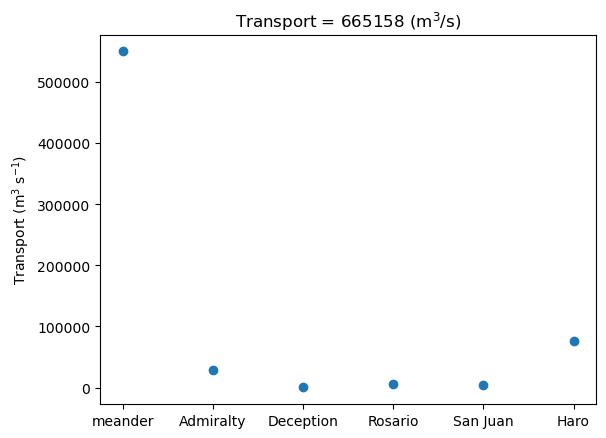

In [14]:
section_trans = []

for section in sectionnum:
    section_trans.append(get_datat(data,section,starttime,endtime))

print(section_trans)

fig,ax = plt.subplots()


sectionplot = sectionnum[0:]
sectionplot[0] = 1

ax.scatter(sectionplot,section_trans)
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','Admiralty','Deception','Rosario','San Juan','Haro']);
ax.set_ylabel(r'Transport (m$^3$ s$^{-1}$)')
ax.set_title(f'Transport = {round(np.sum(section_trans))} (m$^3$/s)')

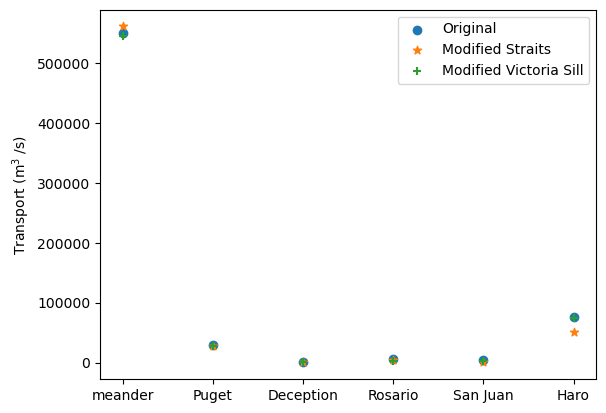

In [15]:
# Alternate boundary for straits
section_transf2 = []

dataf2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18b2/for_straight_01jan18/ariane_positions_quantitative.nc')

for section in sectionnum:
    section_transf2.append(get_datat(dataf2,section,starttime,endtime))

#Alternate boundary for victoria sill
section_transf1 = []

dataf1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18/ariane_positions_quantitative.nc')

for section in sectionnum:
    section_transf1.append(get_datat(dataf1,section,starttime,endtime))


fig,ax = plt.subplots()

ax.scatter(sectionplot,section_trans)
ax.scatter(sectionplot,section_transf2,marker='*')
ax.scatter(sectionplot,section_transf1,marker='+')
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','Puget','Deception','Rosario','San Juan','Haro']);
ax.set_ylabel(f'Transport (m$^3$ /s)')
ax.legend(['Original','Modified Straits','Modified Victoria Sill'])

### Boundary Comparison

#### Rosario

In [16]:
#Interpolate data for depth

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [17]:
salt,transp,lon,lat,depth,section,zfinal,temp = get_data(data)

transp_adm,lon_adm,depth_adm,z_adm,salt_adm,temp_adm = splitsec(section,2,transp,lon,depth,zfinal,salt,temp)
transp_ros,lon_ros,depth_ros,z_ros,salt_ros,temp_ros = splitsec(section,4,transp,lon,depth,zfinal,salt,temp)
transp_haro,lon_haro,depth_haro,z_haro,salt_haro,temp_haro = splitsec(section,6,transp,lon,depth,zfinal,salt,temp)
transp_sjc,lon_sjc,depth_sjc,z_sjc,salt_sjc,temp_sjc = splitsec(section,5,transp,lon,depth,zfinal,salt,temp)

saltf2,transpf2,lonf2,latf2,depthf2,sectionf2,zfinalf2,tempf2 = get_data(dataf2)

transp_admf2,lon_admf2,depth_admf2,z_admf2,salt_admf2,temp_admf2 = splitsec(sectionf2,2,transpf2,lonf2,depthf2,zfinalf2,saltf2,tempf2)
transp_rosf2,lon_rosf2,depth_rosf2,z_rosf2,salt_rosf2,temp_rosf2 = splitsec(sectionf2,4,transpf2,lonf2,depthf2,zfinalf2,saltf2,tempf2)
transp_harof2,lon_harof2,depth_harof2,z_harof2,salt_harof2,temp_harof2 = splitsec(sectionf2,6,transpf2,lonf2,depthf2,zfinalf2,saltf2,tempf2)
transp_sjcf2,lon_sjcf2,depth_sjcf2,z_sjcf2,salt_sjcf2,temp_sjcf2 = splitsec(sectionf2,5,transpf2,lonf2,depthf2,zfinalf2,saltf2,tempf2)



In [18]:
transp_ros
a=f_lons[lonE] - f_lons[lonW]

print(mesh.e2f[0,266,lonE:lonW].sum().values)

print(a/(mesh.e2f[0,266,lonE:lonW].sum().values))

#lat/m (deg/m) - use to convert b/w m and degree


0.0
<xarray.DataArray 'glamf' ()>
array(inf)


Text(0.5, 0.98, 'Admiralty')

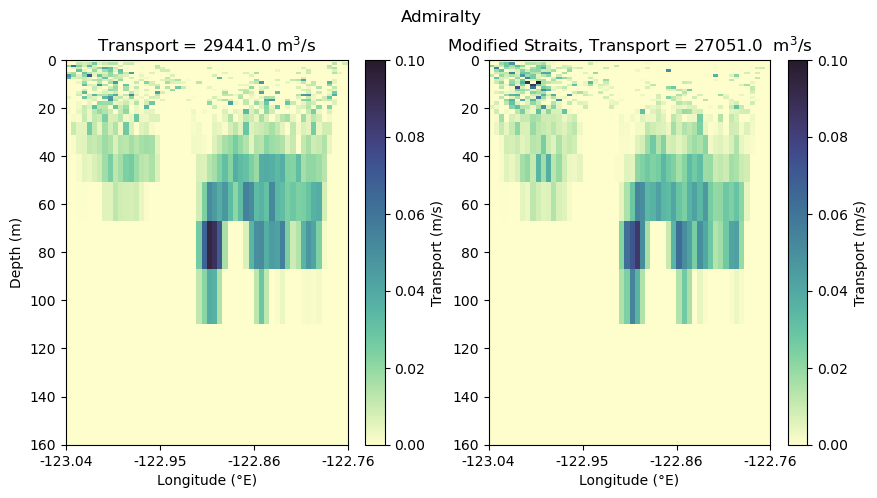

In [19]:
lonWadm = 260
lonEadm = 315
vmax = 0.1
time = endtime-starttime

title = f'Transport = {np.round(section_trans[puget-1])} m$^3$/s'
title2 = f'Modified Straits, Transport = {np.round(section_transf2[puget-1])}  m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_adm,z_adm,transp_adm,lonWadm,lonEadm,30,vmax,time,title,True,True)
plotCS(ax2,lon_admf2,z_admf2,transp_admf2,lonWadm,lonEadm,30,vmax,time,title2,True,False)
fig.suptitle('Admiralty')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Victoria Sill')

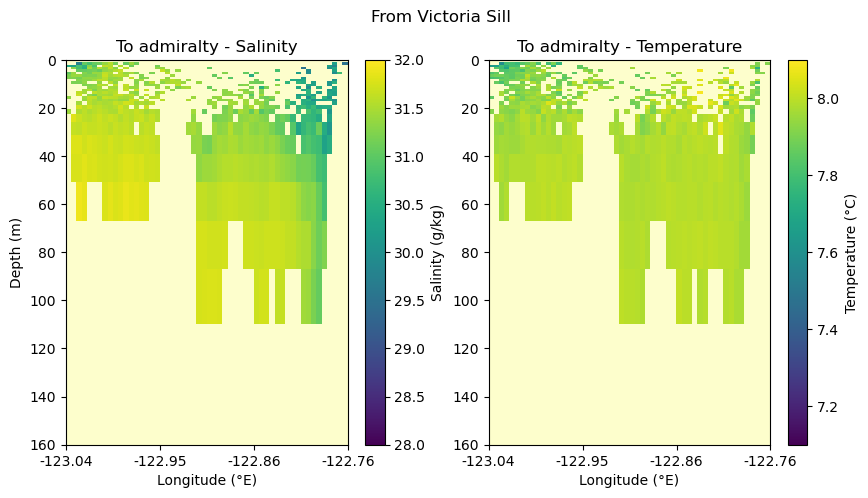

In [20]:
title = 'To admiralty - Salinity'
title2 = 'To admiralty - Temperature'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

tmin = 7.1
tmax = 8.1
smin = 28
smax = 32

plotTS(ax1,'sal',lon_adm,z_adm,salt_adm,lonWadm,lonEadm,30,time,title,True,True,vmin=smin,vmax=smax)
plotTS(ax2,'temp',lon_adm,z_adm,temp_adm,lonWadm,lonEadm,30,time,title2,True,False,vmin=tmin,vmax=tmax)
fig.suptitle('From Victoria Sill')


Text(0.5, 0.98, 'Rosario')

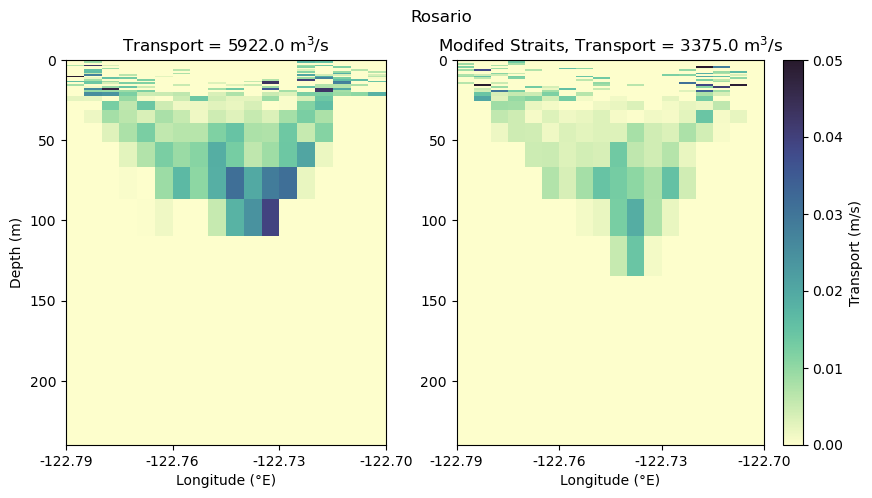

In [21]:
lonWros=308
lonEros=327

title = f'Transport = {np.round(section_trans[rosario-1])} m$^3$/s'
title2 =  f'Modifed Straits, Transport = {np.round(section_transf2[rosario-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.2]})
plotCS(ax1,lon_ros,z_ros,transp_ros,lonWros,lonEros,33,0.05,168,title,False,True)
plotCS(ax2,lon_rosf2,z_rosf2,transp_rosf2,lonWros,lonEros,33,0.05,168,title2,True,False)
fig.suptitle('Rosario')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Rosario from Victoria Sill')

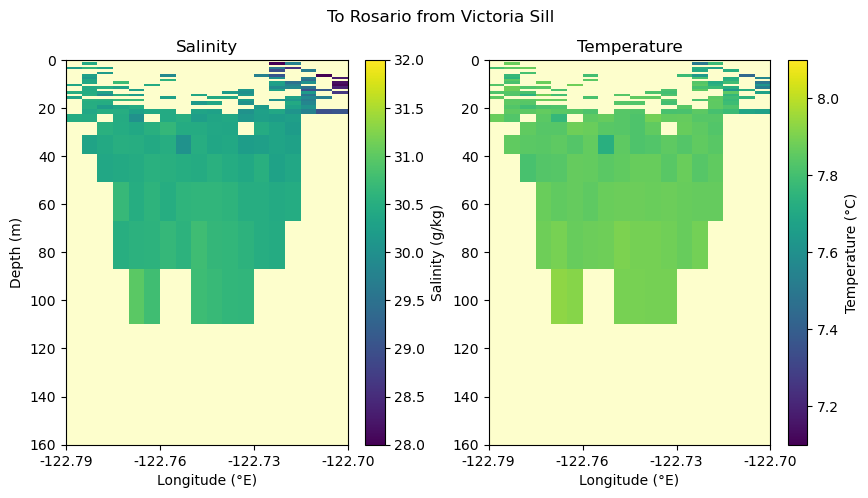

In [22]:
title = 'Salinity'
title2 = 'Temperature'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',lon_ros,z_ros,salt_ros,lonWros,lonEros,30,time,title,True,True,vmin=smin,vmax=smax)
plotTS(ax2,'temp',lon_ros,z_ros,temp_ros,lonWros,lonEros,30,time,title2,True,False,vmin=tmin,vmax=tmax)
fig.suptitle('To Rosario from Victoria Sill')

/tmp/ipykernel_22602/1960477230.py:14: RuntimeWarning: invalid value encountered in divide
  arr3 = arr/arr2


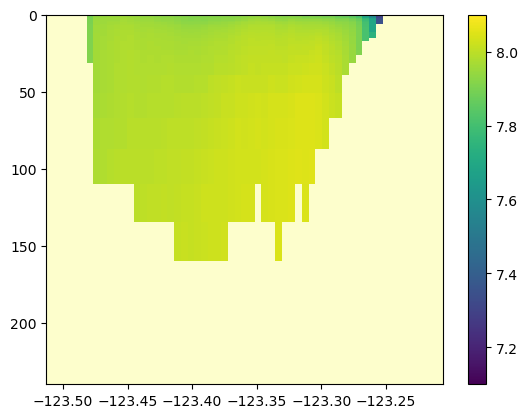

In [23]:
alllon = data.init_lon
allz = data.init_z
allsal = data.init_temp
cmap = cm.deep

lonW = 170
lonE = 230

fig,ax = plt.subplots()

arr,xe,ye,im = ax.hist2d(alllon,df(allz)[0],weights=allsal,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]),w_depths[0,0:33]])
arr2,xe2,ye2,im2 = ax.hist2d(alllon,df(allz)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]),w_depths[0,0:33]])

arr3 = arr/arr2
X,Y = np.meshgrid(xe,ye)


im = ax.pcolormesh(X,Y,arr3.T,vmin=tmin,vmax=tmax)

ax.invert_yaxis()

fig.colorbar(im,ax=ax)

#### Haro

Text(0.5, 0.98, 'Haro')

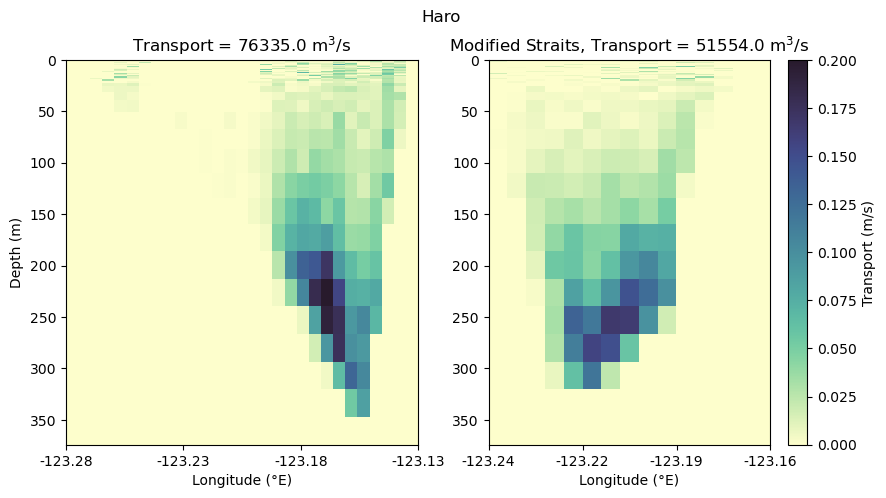

In [24]:
lonWharo = 215
lonEharo = 245

lonW2 = 222
lonE2 = 238

vmax = 0.2

title = f'Transport = {np.round(section_trans[haro-1])} m$^3$/s'
title2 = f'Modified Straits, Transport = {np.round(section_transf2[haro-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))
plotCS(ax1,lon_haro,z_haro,transp_haro,lonWharo,lonEharo,38,vmax,time,title,False,True)
plotCS(ax2,lon_harof2,z_harof2,transp_harof2,lonW2,lonE2,38,vmax,time,title2,True,False)
fig.suptitle('Haro')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Haro from Victoria Sill')

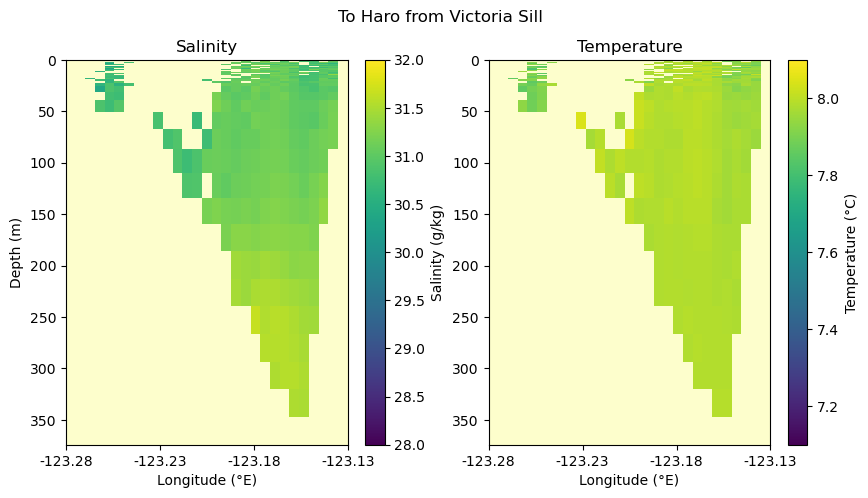

In [25]:
title = 'Salinity'
title2 = 'Temperature'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',lon_haro,z_haro,salt_haro,lonWharo,lonEharo,38,time,title,True,True,vmin=smin,vmax=smax)
plotTS(ax2,'temp',lon_haro,z_haro,temp_haro,lonWharo,lonEharo,38,time,title2,True,False,vmin=tmin,vmax=tmax)
fig.suptitle('To Haro from Victoria Sill')

#### San Juan Channel

Text(0.5, 0.98, 'San Juan Channel')

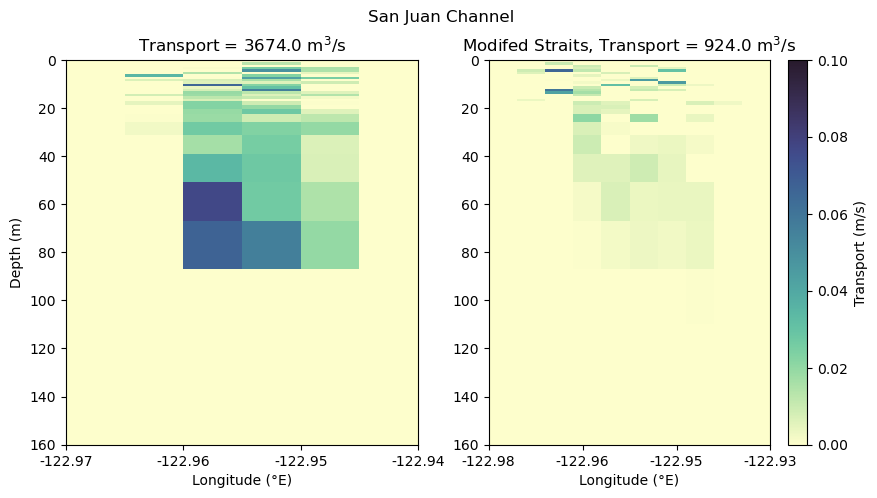

In [26]:
lonWsjc = 274
lonEsjc = 281
vmax = 0.1

lonW2 = 272
lonE2 = 283

title = f'Transport = {np.round(section_trans[sjc-1])} m$^3$/s'
title2 = f'Modifed Straits, Transport = {np.round(section_transf2[sjc-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))
plotCS(ax1,lon_sjc,z_sjc,transp_sjc,lonWsjc,lonEsjc,30,vmax,time,title,False,True)
plotCS(ax2,lon_sjcf2,z_sjcf2,transp_sjcf2,lonW2,lonE2,30,vmax,time,title2,True,False)
fig.suptitle('San Juan Channel')



### Backwards

In [27]:
databack = xr.open_dataset('backPR_jan18/for_straight_15jan18_202111_s1t14/ariane_positions_quantitative.nc')
databack01 = xr.open_dataset('backPR_jan18/for_straight_01jan18_202111_s1t14/ariane_positions_quantitative.nc')
databack29 = xr.open_dataset('backPR_jan18/for_straight_30jan18_202111_s1t28/ariane_positions_quantitative.nc')
databack28 = xr.open_dataset('backPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

pointrob = 1
gulf1 = 2
gulf2 = 3

sectionnumback = [meander,gulf1,gulf2,rosario,sjc,haro]

Text(0.5, 1.0, 'Backwards - Date comparison')

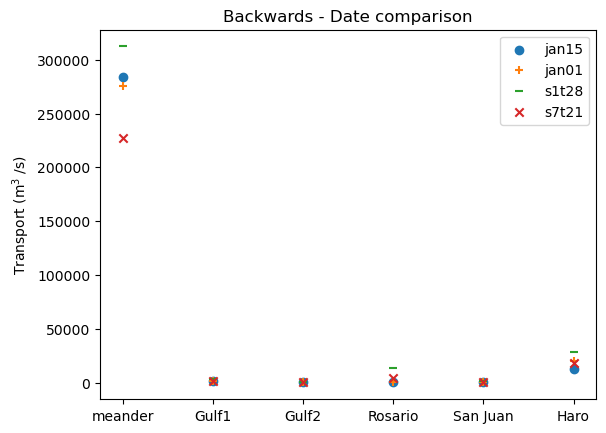

In [28]:
#jan 1 - 15
section_transb = []

#hours seeded
starttime = 1
endtime = 25

for section in sectionnumback:
    section_transb.append(get_datat(databack,section,starttime,endtime))

#dec19 - jan01

section_transb1 = []

for section in sectionnumback:
    section_transb1.append(get_datat(databack01,section,starttime,endtime))

#jan01 - jan29

section_transb3 = []

starttime = 1
endtime = 25

for section in sectionnumback:
    section_transb3.append(get_datat(databack29,section,starttime,endtime))
    
starttimeb4 = 1
endtimeb4 = 169

section_transb4 = []

for section in sectionnumback:
    section_transb4.append(get_datat(databack28,section,starttimeb4,endtimeb4))

fig,ax = plt.subplots()

ax.scatter(sectionplot,section_transb)
ax.scatter(sectionplot,section_transb1,marker='+')
ax.scatter(sectionplot,section_transb3,marker='_')
ax.scatter(sectionplot,section_transb4,marker='x')
ax.legend(['jan15','jan01','s1t28','s7t21'])
ax.set_xticks(sectionplot)
ax.set_ylabel(f'Transport (m$^3$ /s)')
ax.set_xticklabels(['meander','Gulf1','Gulf2','Rosario','San Juan','Haro']);
ax.set_title('Backwards - Date comparison')

Text(0.5, 1.0, 'Backwards - Date comparison')

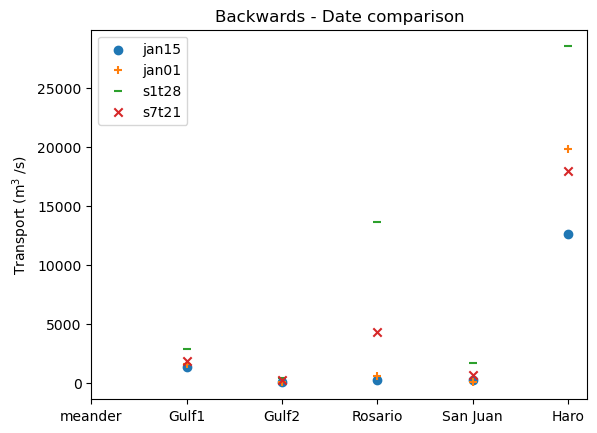

In [29]:
fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transb[1:])
ax.scatter(sectionplot[1:],section_transb1[1:],marker='+')
ax.scatter(sectionplot[1:],section_transb3[1:],marker='_')
ax.scatter(sectionplot[1:],section_transb4[1:],marker='x')
ax.legend(['jan15','jan01','s1t28','s7t21'])
ax.set_xticks(sectionplot)
ax.set_ylabel(f'Transport (m$^3$ /s)')
ax.set_xticklabels(['meander','Gulf1','Gulf2','Rosario','San Juan','Haro']);
ax.set_title('Backwards - Date comparison')

In [30]:
saltb,transpb,lonb,latb,depthb,sectionb,zfinalb,tempb = get_data(databack)

transp_admb,lon_admb,depth_admb,z_admb,salt_admb,temp_admb = splitsec(sectionb,2,transpb,lonb,depthb,zfinalb,saltb,tempb)
transp_rosb,lon_rosb,depth_rosb,z_rosb,salt_rosb,temp_rosb = splitsec(sectionb,4,transpb,lonb,depthb,zfinalb,saltb,tempb)
transp_harob,lon_harob,depth_harob,z_harob,salt_harob,temp_harob = splitsec(sectionb,6,transpb,lonb,depthb,zfinalb,saltb,tempb)
transp_sjcb,lon_sjcb,depth_sjcb,z_sjcb,salt_sjcb,temp_sjcb = splitsec(sectionb,5,transpb,lonb,depthb,zfinalb,saltb,tempb)

saltb2,transpb2,lonb2,latb2,depthb2,sectionb2,zfinalb2,tempb2 = get_data(databack01)

transp_rosb2,lon_rosb2,depth_rosb2,z_rosb2,salt_rosb2,temp_rosb2 = splitsec(sectionb2,4,transpb2,lonb2,depthb2,zfinalb2,saltb2,tempb2)
transp_harob2,lon_harob2,depth_harob2,z_harob2,salt_harob2,temp_harob2 = splitsec(sectionb2,6,transpb2,lonb2,depthb2,zfinalb2,saltb2,tempb2)
transp_sjcb2,lon_sjcb2,depth_sjcb2,z_sjcb2,salt_sjcb2,temp_sjcb2 = splitsec(sectionb2,5,transpb2,lonb2,depthb2,zfinalb2,saltb2,tempb2)

saltb3,transpb3,lonb3,latb3,depthb3,sectionb3,zfinalb3,tempb3 = get_data(databack29)

transp_rosb3,lon_rosb3,depth_rosb3,z_rosb3,salt_rosb3,temp_rosb3 = splitsec(sectionb3,4,transpb3,lonb3,depthb3,zfinalb3,saltb3,tempb3)
transp_harob3,lon_harob3,depth_harob3,z_harob3,salt_harob3,temp_harob3 = splitsec(sectionb3,6,transpb3,lonb3,depthb3,zfinalb3,saltb3,tempb3)
transp_sjcb3,lon_sjcb3,depth_sjcb3,z_sjcb3,salt_sjcb4,temp_sjcb3 = splitsec(sectionb3,5,transpb3,lonb3,depthb3,zfinalb3,saltb3,tempb3)

saltb4,transpb4,lonb4,latb4,depthb4,sectionb4,zfinalb4,tempb4 = get_data(databack28)

transp_rosb4,lon_rosb4,depth_rosb4,z_rosb4,salt_rosb4,temp_rosb4 = splitsec(sectionb4,4,transpb4,lonb4,depthb4,zfinalb4,saltb4,tempb4)
transp_harob4,lon_harob4,depth_harob4,z_harob4,salt_harob4,temp_harob4 = splitsec(sectionb4,6,transpb4,lonb4,depthb4,zfinalb4,saltb4,tempb4)
transp_sjcb4,lon_sjcb4,depth_sjcb4,z_sjcb4,salt_sjcb4,temp_sjcb4 = splitsec(sectionb4,5,transpb4,lonb4,depthb4,zfinalb4,saltb4,tempb4)

#### Rosario

Text(0.5, 0.98, 'Rosario, 1day vs 1week seeding')

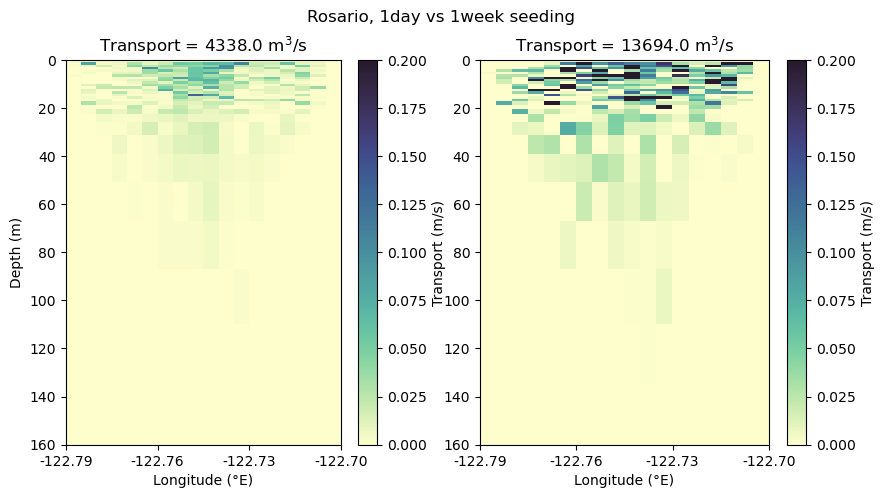

In [31]:
title = f'Transport = {np.round(np.sum(section_transb4[rosario-1]))} m$^3$/s'
title2 = f'Transport = {np.round(np.sum(section_transb3[rosario-1]))} m$^3$/s'

timeb = endtimeb4-starttimeb4
vmax = 0.2

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.05]})

plotCS(ax1,lon_rosb4,z_rosb4,transp_rosb4,lonWros,lonEros,30,vmax,timeb,title,True,True)
plotCS(ax2,lon_rosb3,z_rosb3,transp_rosb3,lonWros,lonEros,30,vmax,25-1,title2,True,False)
fig.suptitle('Rosario, 1day vs 1week seeding')

In [32]:
print(np.sum(transp_rosb3).values)

print(np.sum(transp_rosb4).values)

342349.3060727515
733105.8630332531


#### Haro

Text(0.5, 0.98, 'Haro, seeding 1day vs. 1week')

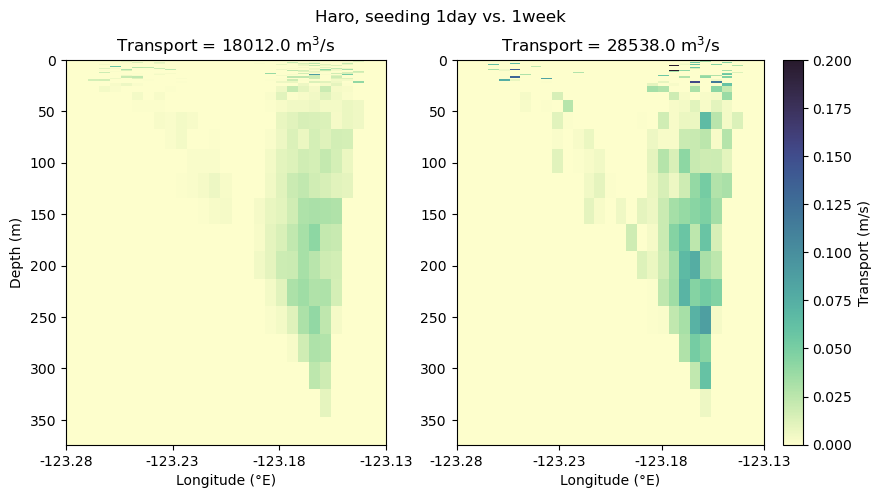

In [33]:
title = f'Transport = {np.round(section_transb4[haro-1])} m$^3$/s'
title2 = f'Transport = {np.round(section_transb3[haro-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.2]})

plotCS(ax1,lon_harob4,z_harob4,transp_harob4,lonWharo,lonEharo,38,vmax,timeb,title,False,True)
plotCS(ax2,lon_harob3,z_harob3,transp_harob3,lonWharo,lonEharo,38,vmax,25-1,title2,True,False)

fig.suptitle('Haro, seeding 1day vs. 1week')

#### San Juan

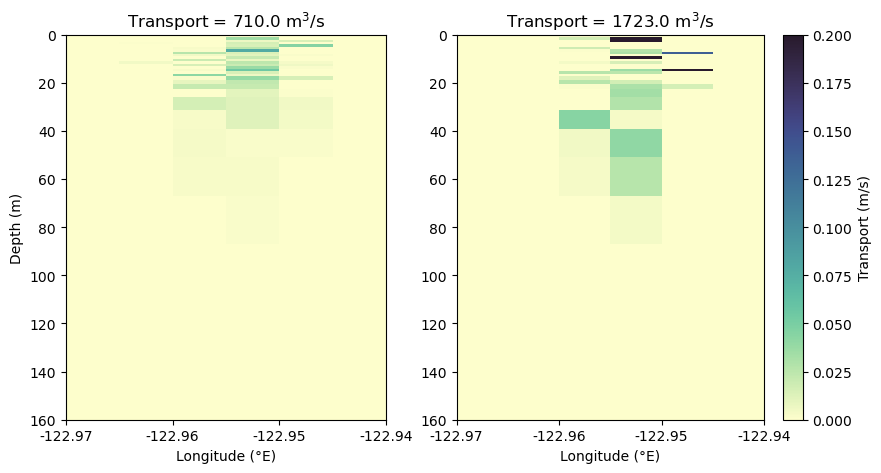

In [34]:
title = f'Transport = {np.round(section_transb4[sjc-1])} m$^3$/s'
title2 = f'Transport = {np.round(section_transb3[sjc-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.2]})

plotCS(ax1,lon_sjcb4,z_sjcb4,transp_sjcb4,lonWsjc,lonEsjc,30,vmax,timeb,title,False,True)
plotCS(ax2,lon_sjcb3,z_sjcb3,transp_sjcb3,lonWsjc,lonEsjc,30,vmax,25-1,title2,True,False)

Text(0.5, 0.98, 'Point Roberts - Backwards')

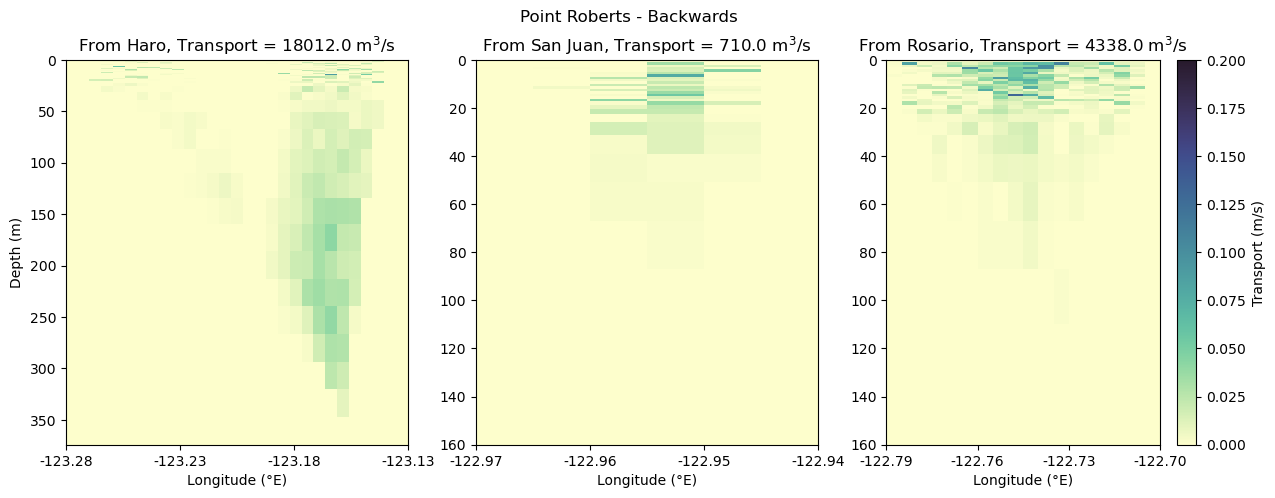

In [35]:
lonWharo = 215

title = f'From Haro, Transport = {np.round(section_transb4[haro-1])} m$^3$/s'
title2 = f'From Rosario, Transport = {np.round(section_transb4[rosario-1])} m$^3$/s'
title3 = f'From San Juan, Transport = {np.round(section_transb4[sjc-1])} m$^3$/s'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotCS(ax1,lon_harob4,z_harob4,transp_harob4,lonWharo,lonEharo,38,vmax,timeb,title,False,True)
plotCS(ax3,lon_rosb4,z_rosb4,transp_rosb4,lonWros,lonEros,30,vmax,timeb,title2,True,False)
plotCS(ax2,lon_sjcb4,z_sjcb4,transp_sjcb4,lonWsjc,lonEsjc,30,vmax,timeb,title3,False,False)

fig.suptitle('Point Roberts - Backwards')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Point Roberts - Salinity')

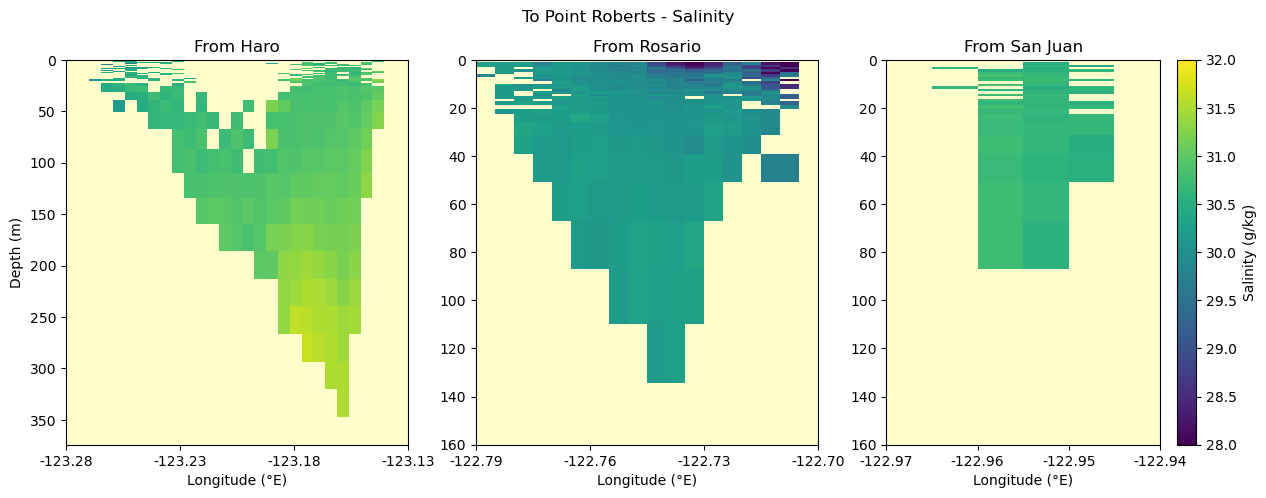

In [36]:
#Compare salinity b/w the 3

title = 'From Haro'
title2 = 'From Rosario'
title3 = 'From San Juan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_harob4,z_harob4,salt_harob4,lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_rosb4,z_rosb4,salt_rosb4,lonWros,lonEros,30,time,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_sjcb4,z_sjcb4,salt_sjcb4,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=smin,vmax=smax)

fig.suptitle('To Point Roberts - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Point Roberts - Temperature')

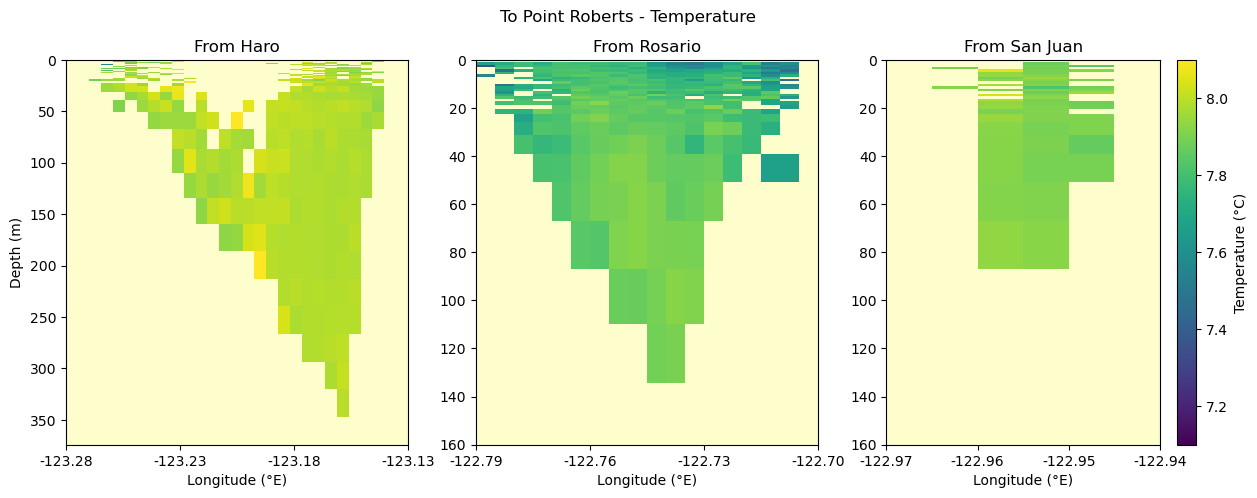

In [37]:
title = 'From Haro'
title2 = 'From Rosario'
title3 = 'From San Juan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',lon_harob4,z_harob4,temp_harob4,lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_rosb4,z_rosb4,temp_rosb4,lonWros,lonEros,30,time,title2,False,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',lon_sjcb4,z_sjcb4,temp_sjcb4,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('To Point Roberts - Temperature')

#### Seeding from Haro

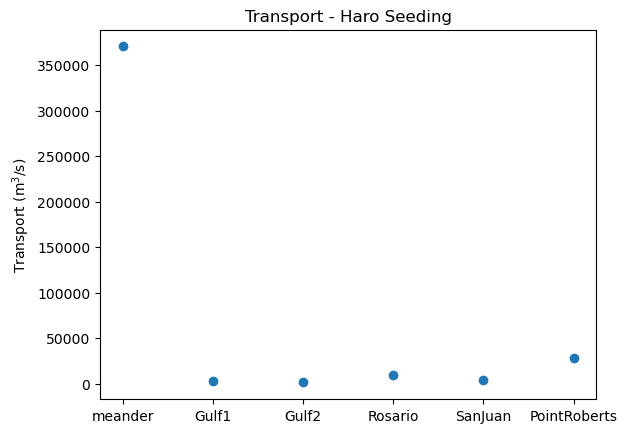

In [38]:
#Import data
datafhspr = xr.open_dataset('forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

starttime = 1
endtime = 168

harohs = 1
gulf1 = 2
gulf2 = 3
pointrobhs = 6

sectionnumhs = [meander, gulf1, gulf2,rosario,sjc,pointrobhs ]

section_transpfhspr = []

for section in sectionnumhs:
    section_transpfhspr.append(get_datat(datafhspr,section,starttime,endtime,))
    

fig,ax = plt.subplots()

ax.scatter(sectionplot,section_transpfhspr)
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','Gulf1','Gulf2','Rosario','SanJuan','PointRoberts'])
ax.set_ylabel(f'Transport (m$^3$/s)');
ax.set_title('Transport - Haro Seeding')

time68 = endtime-starttime

Text(0.5, 0.98, 'Comparing transport from haro and victoria sill')

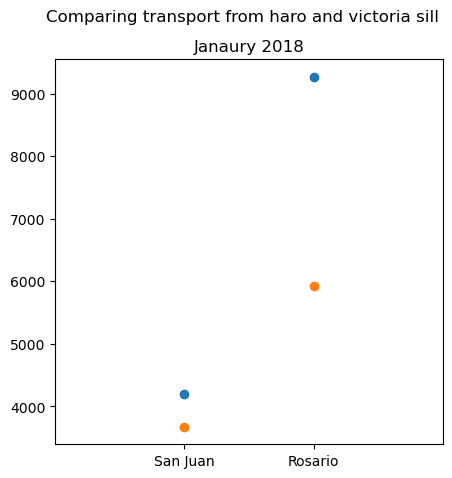

In [39]:
# Compare transport to san juan and rosario from haro vs. from victoria sill
totalhs = 428093
totalvs = 665620

fig,ax = plt.subplots(1,1,figsize=(5,5))

section_transp102 = np.array([section_transpfhspr[sjc-1],section_transpfhspr[rosario-1]])
section_transp103 = np.array([section_trans[sjc-1],section_trans[rosario-1]])

ax.scatter([1,2],section_transp102)
ax.scatter([1,2],section_transp103)
ax.set_xticks([1,2])
ax.set_xticklabels(['San Juan','Rosario'])
ax.set_xlim([0,3])
ax.set_title('Janaury 2018')
fig.suptitle('Comparing transport from haro and victoria sill')

#### Section plots

In [40]:
salths,transphs,lonhs,laths,depthhs,sectionhs,zfinalhs,temphs = get_data(datafhspr)

trans_roshs,lon_roshs,depth_roshs,z_roshs,salt_roshs,temp_roshs = splitsec(sectionhs,4,transphs,lonhs,depthhs,zfinalhs,salths,temphs)
trans_sjchs,lon_sjchs,depth_sjchs,z_sjchs,salt_sjchs,temp_sjchs = splitsec(sectionhs,5,transphs,lonhs,depthhs,zfinalhs,salths,temphs)
trans_prhs,lon_prhs,depth_prhs,z_prhs,salt_prhs,temp_prhs = splitsec(sectionhs,6,transphs,lonhs,depthhs,zfinalhs,salths,temphs)

Text(0.5, 0.98, 'From Haro')

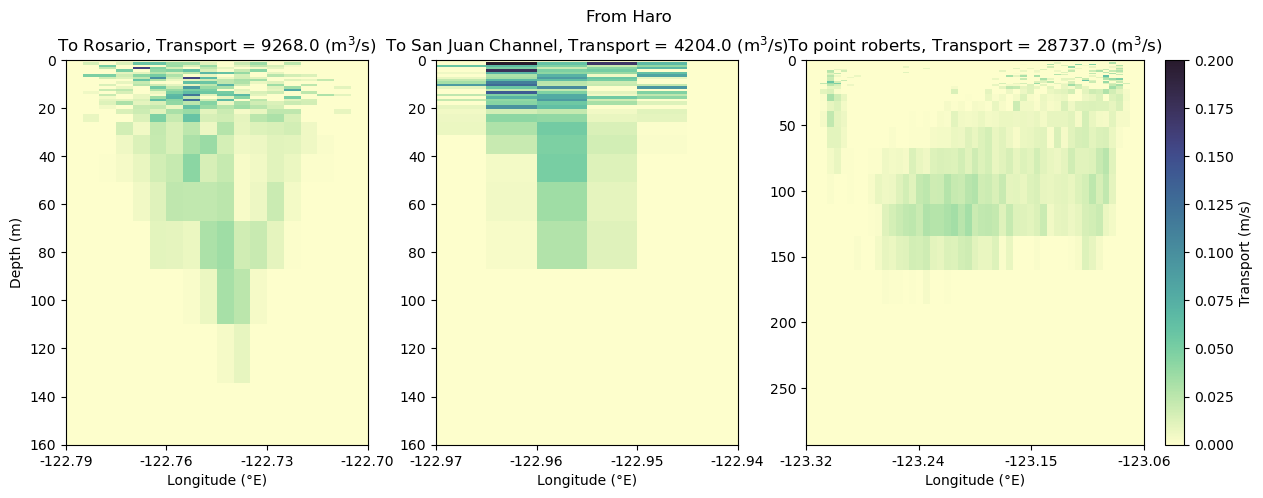

In [41]:
lonWpr = 207
lonEpr = 257

title = f'To Rosario, Transport = {np.round(section_transpfhspr[rosario-1])} (m$^3$/s)'
title2 = f'To San Juan Channel, Transport = {np.round(section_transpfhspr[sjc-1])} (m$^3$/s)'
title3 = f'To point roberts, Transport = {np.round(section_transpfhspr[pointrobhs-1])} (m$^3$/s)'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,1.4]})

plotCS(ax1,lon_roshs,z_roshs,trans_roshs,lonWros,lonEros,30,vmax,time,title,False,True)
plotCS(ax2,lon_sjchs,z_sjchs,trans_sjchs,lonWsjc,lonEsjc,30,vmax,time,title2,False,False)
plotCS(ax3,lon_prhs,z_prhs,trans_prhs,lonWpr,lonEpr,35,vmax,time,title3,True,False)

fig.suptitle('From Haro')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Haro - Salinity')

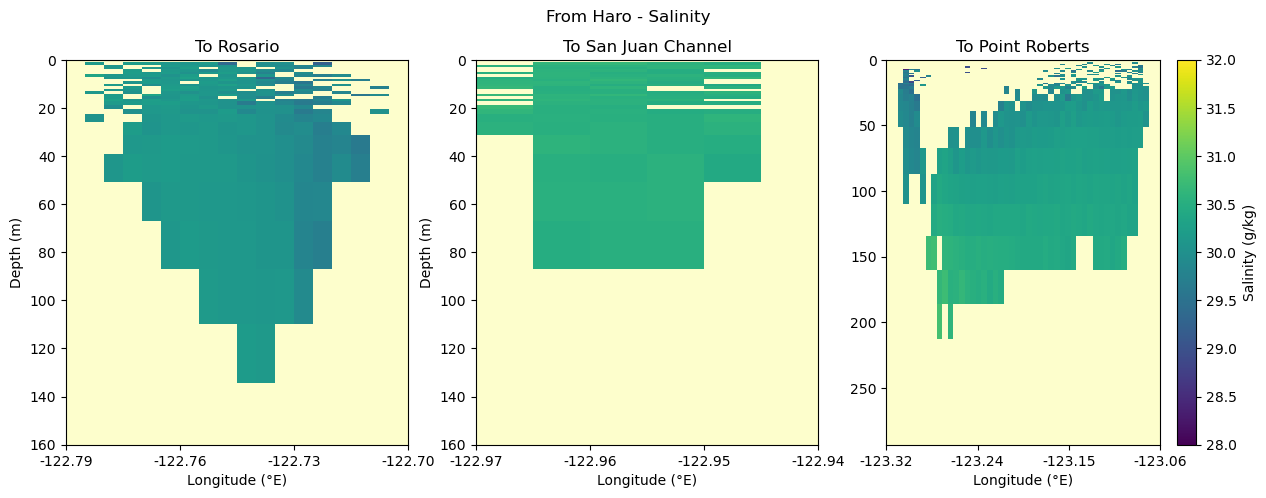

In [42]:
title = 'To Rosario'
title2 = 'To San Juan Channel'
title3 = 'To Point Roberts'

smin = 28
smax = 32

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_roshs,z_roshs,salt_roshs,lonWros,lonEros,30,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_sjchs,z_sjchs,salt_sjchs,lonWsjc,lonEsjc,30,time,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_prhs,z_prhs,salt_prhs,lonWpr,lonEpr,35,time,title3,True,False,vmin=smin,vmax=smax)

fig.suptitle('From Haro - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Haro - Temperature')

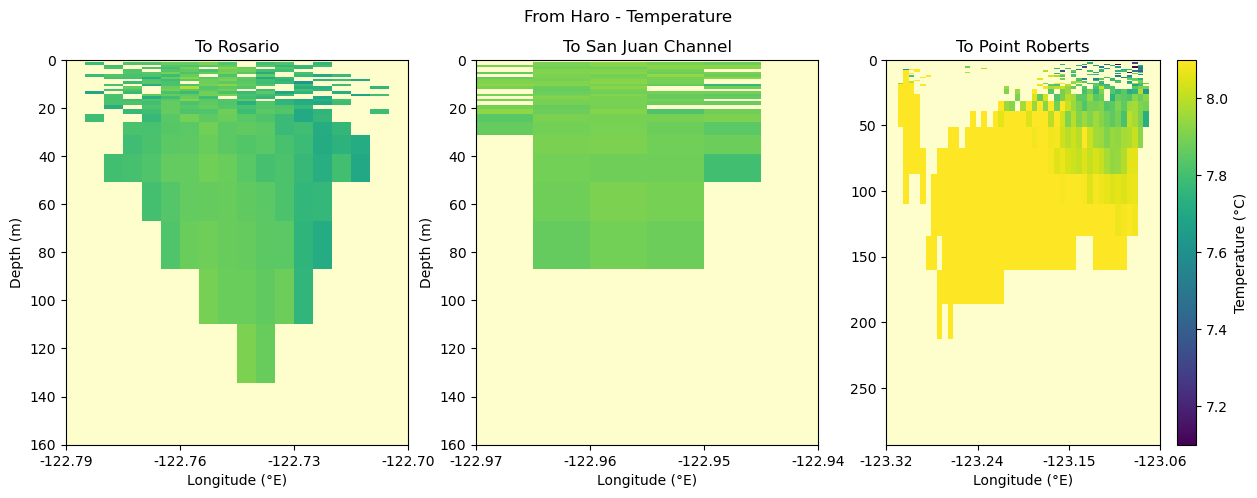

In [43]:
title = 'To Rosario'
title2 = 'To San Juan Channel'
title3 = 'To Point Roberts'

# tmax = 8.5

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',lon_roshs,z_roshs,temp_roshs,lonWros,lonEros,30,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_sjchs,z_sjchs,temp_sjchs,lonWsjc,lonEsjc,30,time,title2,False,True,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',lon_prhs,z_prhs,temp_prhs,lonWpr,lonEpr,35,time,title3,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('From Haro - Temperature')

/tmp/ipykernel_22602/3013899190.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arr/arr2


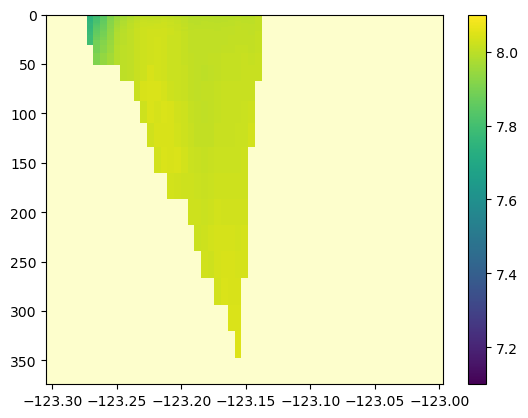

In [44]:
fig,ax = plt.subplots()

arr,xe,ye,im = ax.hist2d(datafhspr.init_lon,df(datafhspr.init_z)[0],weights=datafhspr.init_temp,cmap=cmap,bins=[np.array(f_lons[210:270:1]),w_depths[0,0:38]])
arr2,xe2,ye2,im2 = ax.hist2d(datafhspr.init_lon,df(datafhspr.init_z)[0],cmap=cmap,bins=[np.array(f_lons[210:270:1]),w_depths[0,0:38]])

ax.invert_yaxis()

X,Y = np.meshgrid(xe,ye)

arr3 = arr/arr2

im = ax.pcolormesh(X,Y,arr3.T,vmin=tmin,vmax=tmax)

cb = fig.colorbar(im,ax=ax)


##### Comparision

In [45]:
losths = 11228
lostvs = 462

##### Rosario

Text(0.5, 0.98, 'To Rosario')

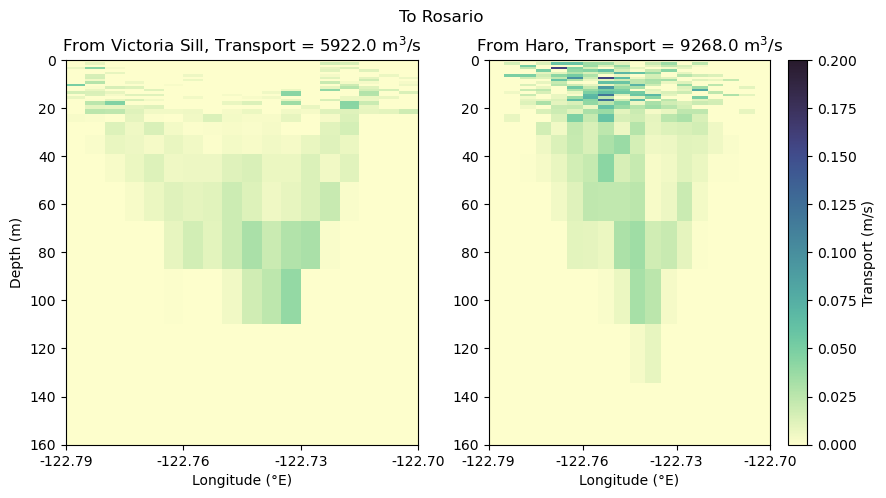

In [46]:
title = f'From Victoria Sill, Transport = {np.round(section_trans[rosario-1])} m$^3$/s'
title2 = f'From Haro, Transport = {np.round(section_transpfhspr[rosario-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_ros,z_ros,transp_ros,lonWros,lonEros,30,vmax,time,title,False,True)
plotCS(ax2,lon_roshs,z_roshs,trans_roshs,lonWros,lonEros,30,vmax,time,title2,True,False)

fig.suptitle('To Rosario')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Rosario - Salinity')

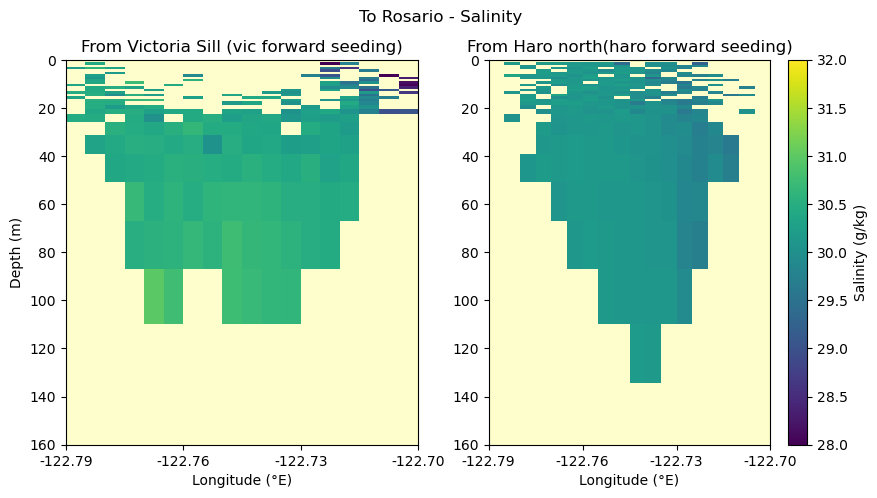

In [47]:
title = 'From Victoria Sill (vic forward seeding)'
title2 = 'From Haro north(haro forward seeding)'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',lon_ros,z_ros,salt_ros,lonWros,lonEros,30,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_roshs,z_roshs,salt_roshs,lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)
fig.suptitle('To Rosario - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Rosario - Temperature')

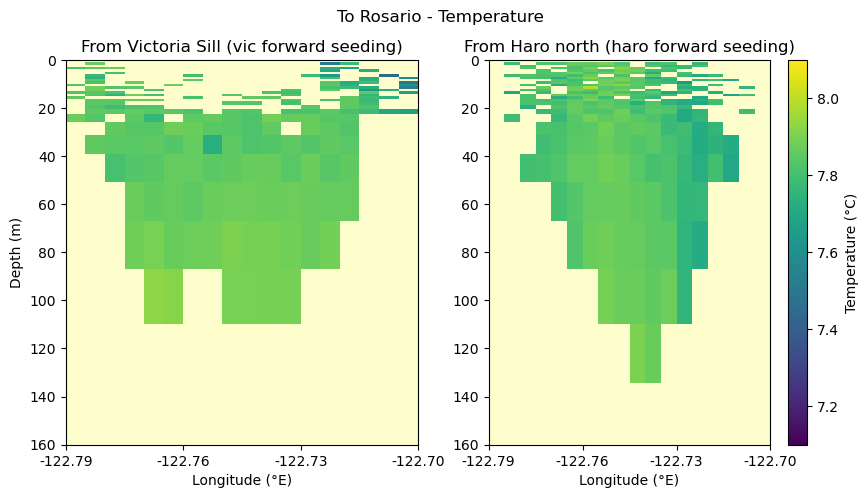

In [48]:
title = 'From Victoria Sill (vic forward seeding)'
title2 = 'From Haro north (haro forward seeding)'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'temp',lon_ros,z_ros,temp_ros,lonWros,lonEros,30,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_roshs,z_roshs,temp_roshs,lonWros,lonEros,30,time,title2,True,False,vmin=tmin,vmax=tmax)
fig.suptitle('To Rosario - Temperature')

Lower temp on mainland side is consistent with what's observed at point roberts.

##### San Juan

Text(0.5, 0.98, 'San Juan Channel')

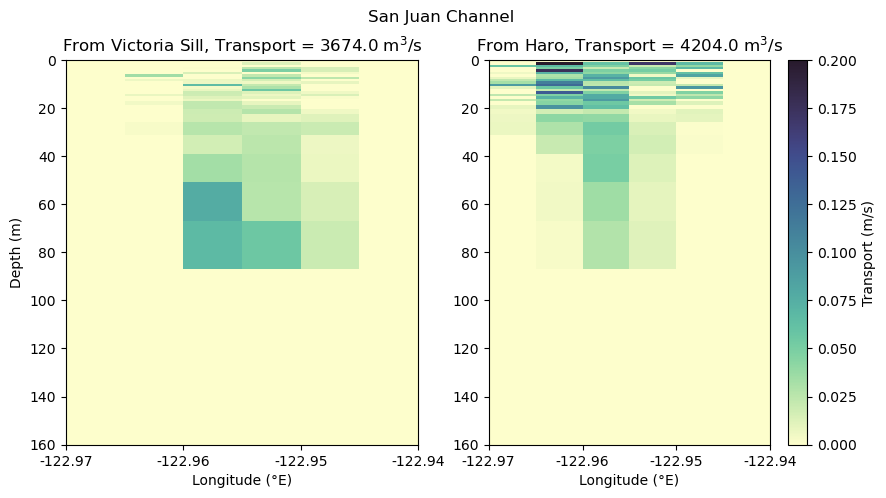

In [49]:
title = f'From Victoria Sill, Transport = {np.round(section_trans[sjc-1])} m$^3$/s'
title2 = f'From Haro, Transport = {np.round(section_transpfhspr[sjc-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_sjc,z_sjc,transp_sjc,lonWsjc,lonEsjc,30,vmax,time,title,False,True)
plotCS(ax2,lon_sjchs,z_sjchs,trans_sjchs,lonWsjc,lonEsjc,30,vmax,time,title2,True,False)
fig.suptitle('San Juan Channel')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'San Juan Channel - Salinity')

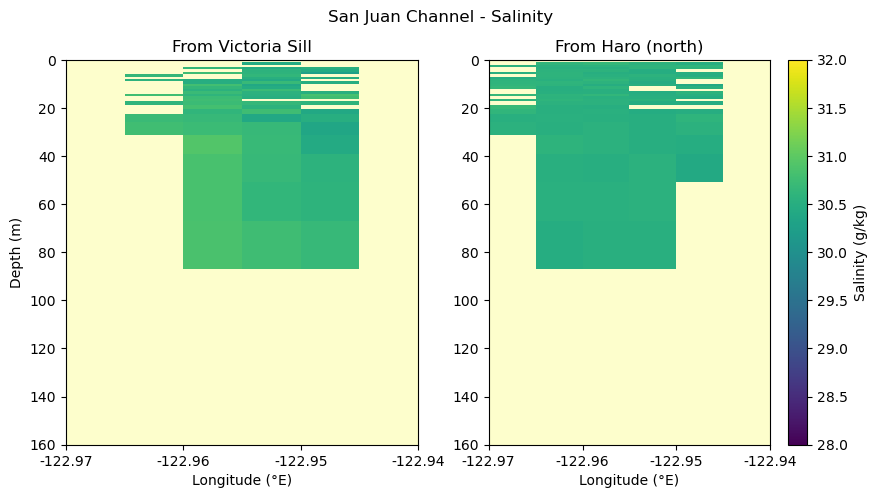

In [50]:
title = 'From Victoria Sill'
title2 = 'From Haro (north)'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',lon_sjc,z_sjc,salt_sjc,lonWsjc,lonEsjc,30,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_sjchs,z_sjchs,salt_sjchs,lonWsjc,lonEsjc,30,time,title2,True,False,vmin=smin,vmax=smax)

fig.suptitle('San Juan Channel - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'San Juan Channel - Temperature')

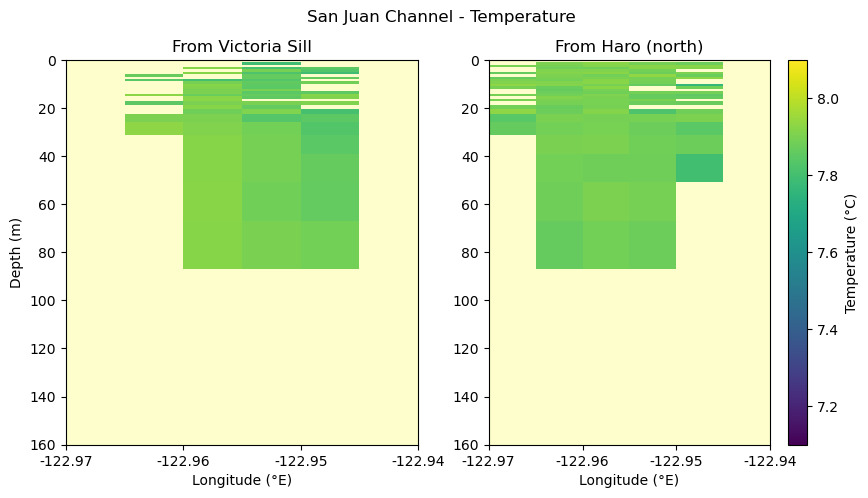

In [51]:
title = 'From Victoria Sill'
title2 = 'From Haro (north)'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'temp',lon_sjc,z_sjc,temp_sjc,lonWsjc,lonEsjc,30,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_sjchs,z_sjchs,temp_sjchs,lonWsjc,lonEsjc,30,time,title2,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('San Juan Channel - Temperature')

### Forwards (from Point Roberts)

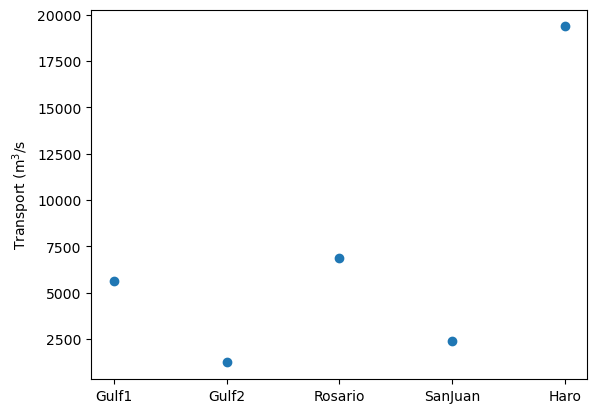

In [52]:
dataforPR = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

starttime = 1
enddtime = 168

section_transpr = []

for section in sectionnum:
    section_transpr.append(get_datat(dataforPR,section,starttime,endtime))

fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transpr[1:])
ax.set_xticks(sectionplot[1:])
ax.set_ylabel(f'Transport (m$^3$/s')
ax.set_xticklabels(['Gulf1','Gulf2','Rosario','SanJuan','Haro']);

In [53]:
saltpr,transpr,lonpr,latpr,depthpr,sectionpr,z_finalpr,temppr = get_data(dataforPR)

transp_haropr,lon_haropr,depth_haropr,z_haropr,salt_haropr,temp_haropr = splitsec(sectionpr,6,transpr,lonpr,depthpr,z_finalpr,saltpr,temppr)
transp_rospr,lon_rospr,depth_rospr,z_rospr,salt_rospr,temp_rospr = splitsec(sectionpr,4,transpr,lonpr,depthpr,z_finalpr,saltpr,temppr)
transp_sjcpr,lon_sjcpr,depth_sjcpr,z_sjcpr,salt_sjcpr,temp_sjcpr = splitsec(sectionpr,5,transpr,lonpr,depthpr,z_finalpr,saltpr,temppr)

Text(0.5, 0.98, 'Point Roberts - Forwards')

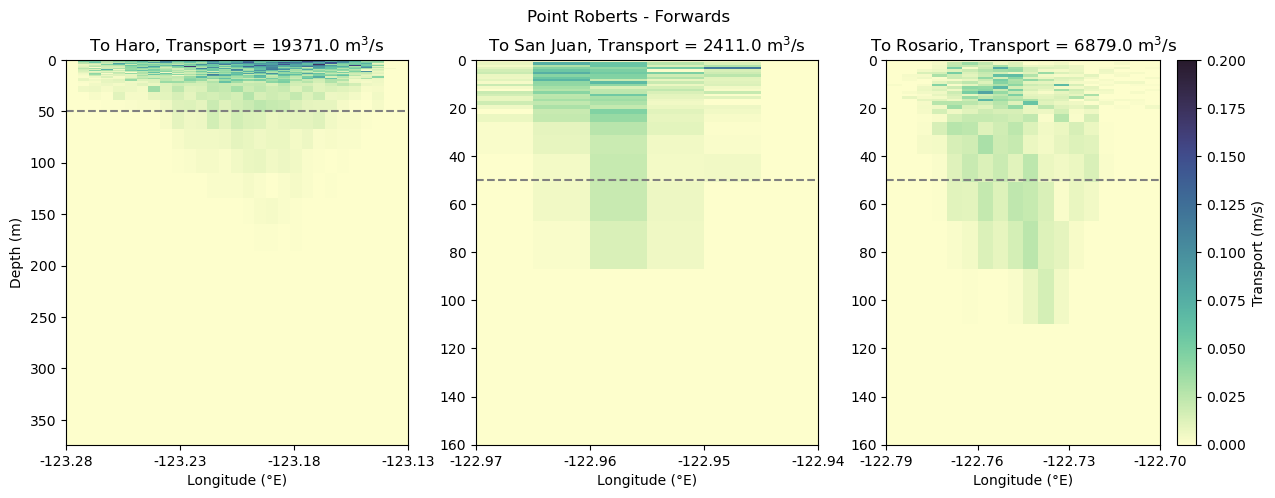

In [54]:
title = f'To Haro, Transport = {np.round(section_transpr[haro-1])} m$^3$/s'
title2 = f'To Rosario, Transport = {np.round(section_transpr[rosario-1])} m$^3$/s'
title3 = f'To San Juan, Transport = {np.round(section_transpr[sjc-1])} m$^3$/s'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotCS(ax1,lon_haropr,z_haropr,transp_haropr,lonWharo,lonEharo,38,vmax,time,title,False,True)
plotCS(ax3,lon_rospr,z_rospr,transp_rospr,lonWros,lonEros,30,vmax,time,title2,True,False)
plotCS(ax2,lon_sjcpr,z_sjcpr,transp_sjcpr,lonWsjc,lonEsjc,30,vmax,time,title3,False,False)
ax1.axhline(50,c='grey',ls='--')
ax2.axhline(50,c='grey',ls='--')
ax3.axhline(50,c='grey',ls='--')

fig.suptitle('Point Roberts - Forwards')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Point Roberts Forwards - Salinity')

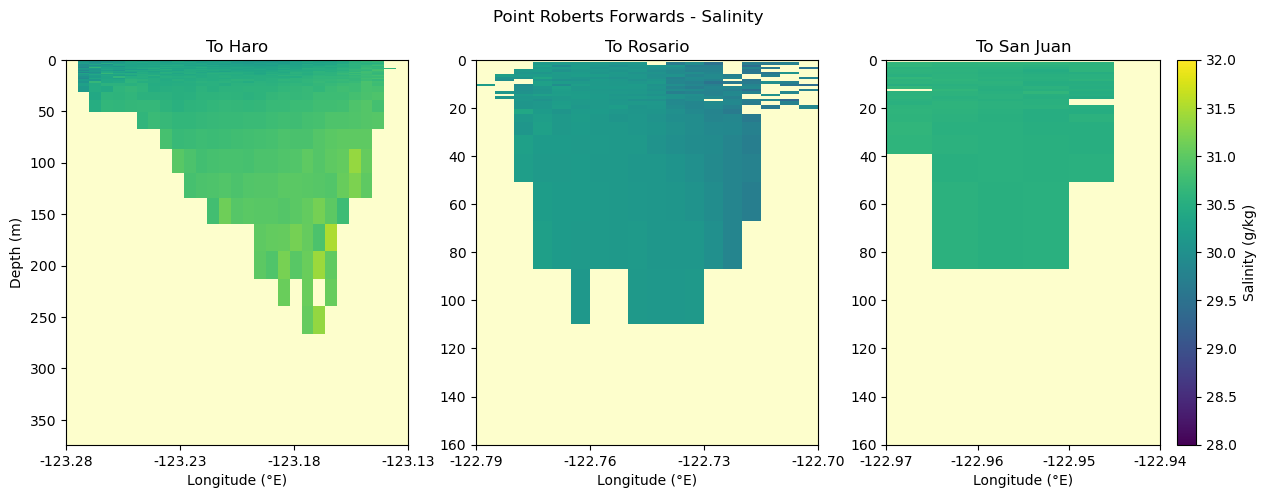

In [55]:
title = 'To Haro'
title2 = 'To Rosario'
title3 = 'To San Juan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_haropr,z_haropr,salt_haropr,lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal', lon_rospr,z_rospr,salt_rospr,lonWros,lonEros,30,time,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_sjcpr,z_sjcpr,salt_sjcpr,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=smin,vmax=smax)

fig.suptitle('Point Roberts Forwards - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Point Roberts Forwards - Temperature')

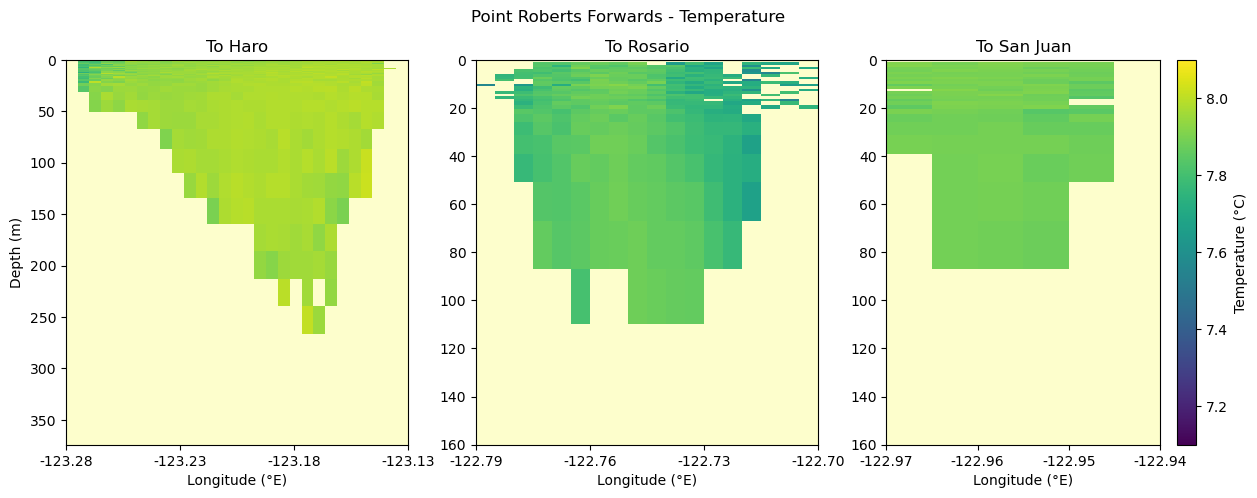

In [56]:
title = 'To Haro'
title2 = 'To Rosario'
title3 = 'To San Juan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',lon_haropr,z_haropr,temp_haropr,lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp', lon_rospr,z_rospr,temp_rospr,lonWros,lonEros,30,time,title2,False,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',lon_sjcpr,z_sjcpr,temp_sjcpr,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('Point Roberts Forwards - Temperature')

Text(0.5, 0.98, 'To Haro')

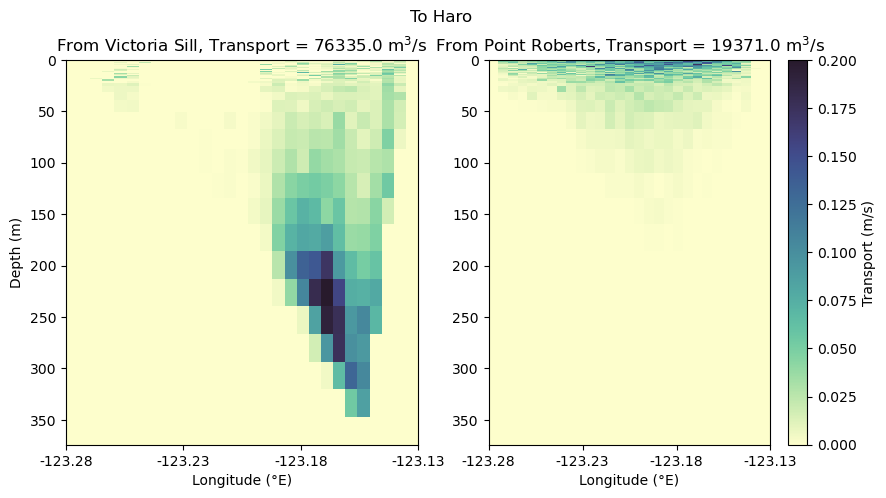

In [57]:
title = f'From Victoria Sill, Transport = {np.round(section_trans[haro-1])} m$^3$/s'
title2 = f'From Point Roberts, Transport = {np.round(section_transpr[haro-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_haro,z_haro,transp_haro,lonWharo,lonEharo,38,vmax,time,title,False,True)
plotCS(ax2,lon_haropr,z_haropr,transp_haropr,lonWharo,lonEharo,38,vmax,time,title2,True,False)

fig.suptitle('To Haro')

Text(0.5, 0.98, 'To Rosario')

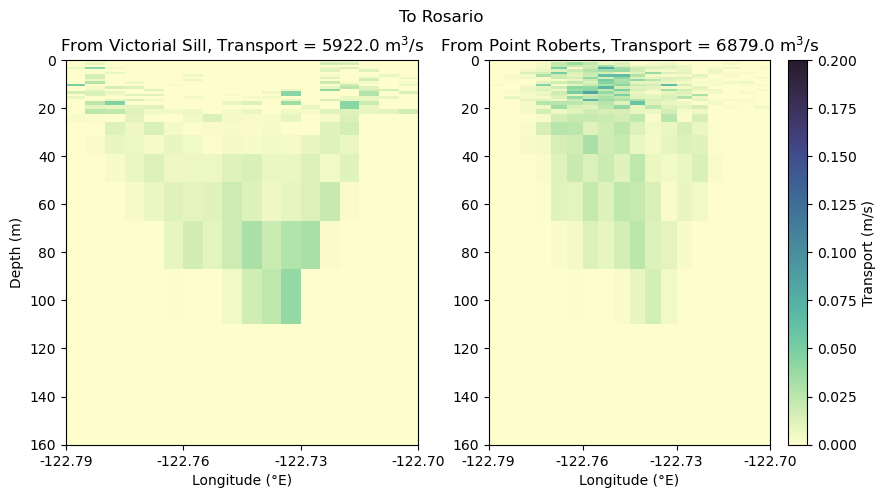

In [58]:
title = f'From Victorial Sill, Transport = {np.round(section_trans[rosario-1])} m$^3$/s'
title2 = f'From Point Roberts, Transport = {np.round(section_transpr[rosario-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_ros,z_ros,transp_ros,lonWros,lonEros,30,vmax,time,title,False,True)
plotCS(ax2,lon_rospr,z_rospr,transp_rospr,lonWros,lonEros,30,vmax,time,title2,True,False)

fig.suptitle('To Rosario')

Text(0.5, 0.98, 'To San Juan')

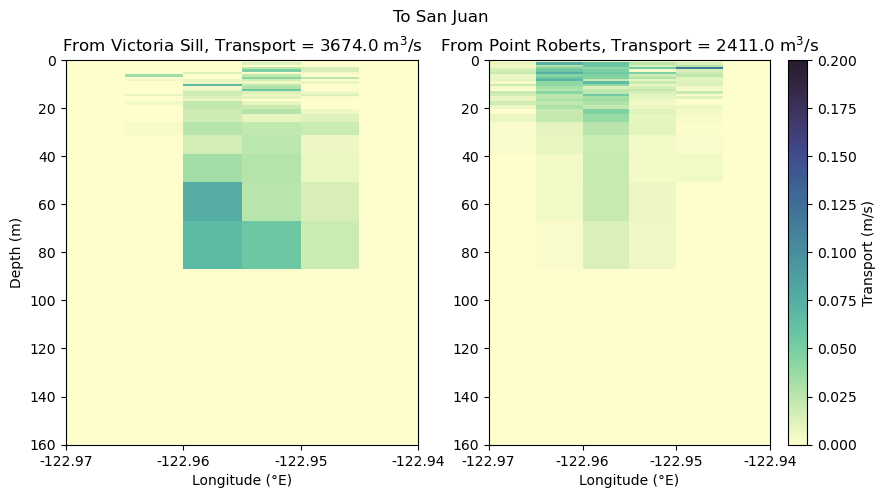

In [59]:
title = f'From Victoria Sill, Transport = {np.round(section_trans[sjc-1])} m$^3$/s'
title2 = f'From Point Roberts, Transport = {np.round(section_transpr[sjc-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_sjc,z_sjc,transp_sjc,lonWsjc,lonEsjc,30,vmax,time,title,False,True)
plotCS(ax2,lon_sjcpr,z_sjcpr,transp_sjcpr,lonWsjc,lonEsjc,30,vmax,time,title2,True,False)

fig.suptitle('To San Juan')

### Rosario Seeding

#### Backwards - Point Roberts

In [60]:
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbrspr = []

rosariors = 1
pointrobrs = 4

starttime = 1
endtime = 169

sectionnumrs = [meander,gulf1,gulf2,pointrobrs,sjc,haro]

for section in sectionnumrs:
    section_transpbrspr.append(get_datat(databrspr,section,starttime,endtime))
    
section_transpbrspr

[71564.83141244487,
 115.20182191318207,
 87.41974116396953,
 3573.7568929419367,
 402.31565466217614,
 4803.9068054766585]

Text(0.5, 1.0, 'January')

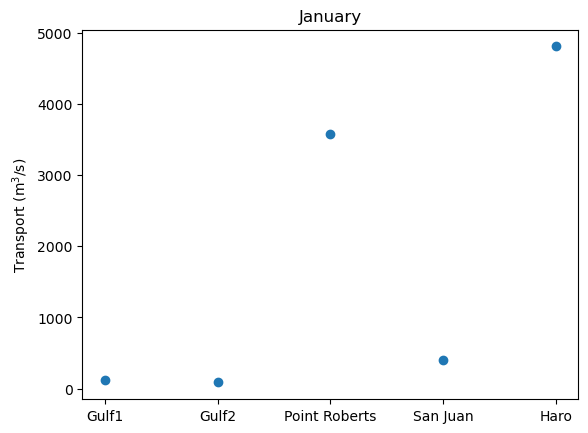

In [61]:
fig,ax = plt.subplots()

ax.scatter(sectionnumrs[1:],section_transpbrspr[1:])
ax.set_xticks(sectionnumrs[1:])
ax.set_xticklabels(['Gulf1','Gulf2','Point Roberts','San Juan','Haro'])
ax.set_ylabel(f'Transport (m$^3$/s)')
ax.set_title('January')


In [62]:
saltbrs,transpbrs,lonbrs,latrs,depthbrs,sectionbrs,z_finalbrs,tempbrs = get_data(databrspr)

transp_harobrs,lon_harobrs,depth_harobrs,z_harobrs,salt_harobrs,temp_harobrs = splitsec(sectionbrs,6,transpbrs,lonbrs,depthbrs,z_finalbrs,saltbrs,tempbrs)
transp_prbrs,lon_prbrs,depth_prbrs,z_prbrs,salt_prbrs,temp_prbrs = splitsec(sectionbrs,4,transpbrs,lonbrs,depthbrs,z_finalbrs,saltbrs,tempbrs)
transp_sjcbrs,lon_sjcbrs,depth_sjcbrs,z_sjcbrs,salt_sjcbrs,temp_sjcbrs = splitsec(sectionbrs,5,transpbrs,lonbrs,depthbrs,z_finalbrs,saltbrs,tempbrs)

z_prbrs

<xarray.DataArray 'final_z' (ntraj: 953)>
[953 values with dtype=float64]
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_z ?
    longname:  Final position in z (or k)
    units:     No dimension

In [63]:
timeb

168

Text(0.5, 0.98, 'To rosario (north)')

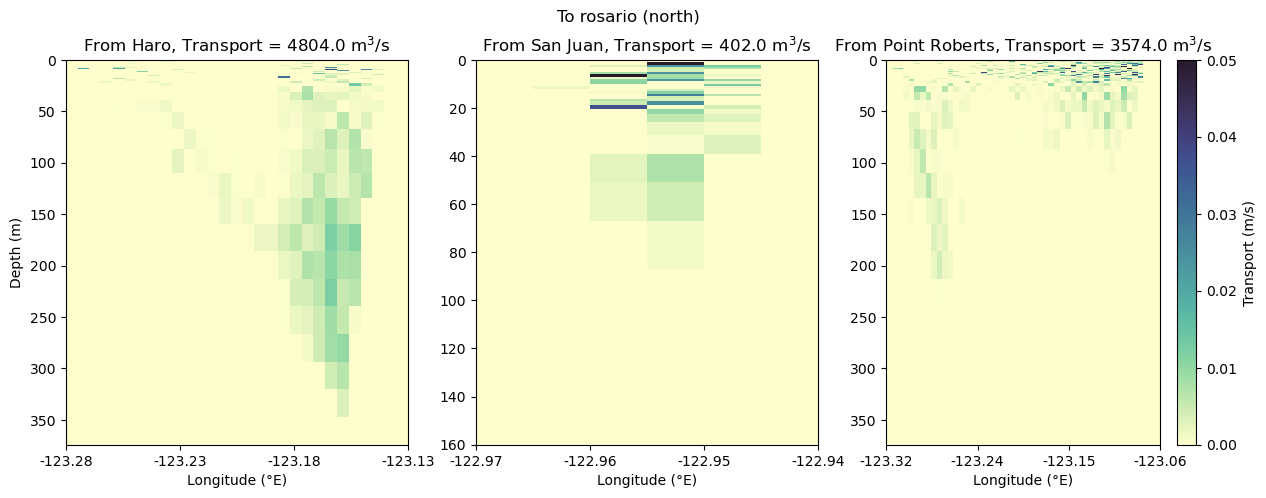

In [64]:
title = f'From Haro, Transport = {np.round(section_transpbrspr[haro-1])} m$^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transpbrspr[sjc-1])} m$^3$/s'
title3 = f'From Point Roberts, Transport = {np.round(section_transpbrspr[pointrobrs-1])} m$^3$/s'
vmax = 0.05

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotCS(ax1,lon_harobrs,z_harobrs,transp_harobrs,lonWharo,lonEharo,38,vmax,timeb,title,False,True)
plotCS(ax2,lon_sjcbrs,z_sjcbrs,transp_sjcbrs,lonWsjc,lonEsjc,30,vmax,timeb,title2,False,False)
plotCS(ax3,lon_prbrs,z_prbrs,transp_prbrs,lonWpr,lonEpr,38,vmax,timeb,title3,True,False)

fig.suptitle('To rosario (north)')



#### Forwards - Point Roberts

In [65]:
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfrspr = []

starttime = 1
endtime = 168

for section in sectionnumrs:
    section_transpfrspr.append(get_datat(datafrspr,section,starttime,endtime))
    
section_transpfrspr

[98921.07260631045,
 17.655330410049007,
 29.096966399520664,
 3644.947766215675,
 256.2452733692517,
 675.5314984362897]

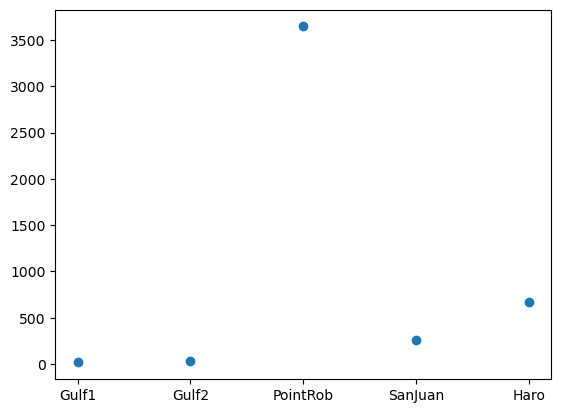

In [66]:
fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transpfrspr[1:])
ax.set_xticks(sectionplot[1:])
ax.set_xticklabels(['Gulf1','Gulf2','PointRob','SanJuan','Haro']);

In [67]:
saltfrspr,transpfrspr,lonfrspr,latfrspr,depthfrspr,sectionfrspr,z_finalfrspr,tempfrspr = get_data(datafrspr)

#PR,SJC,Haro

transp_prfrspr,lon_prfrspr,depth_prfrspr,z_prfrspr,salt_prfrspr,temp_prfrspr = splitsec(sectionfrspr,4,transpfrspr,lonfrspr,depthfrspr,z_finalfrspr,saltfrspr,tempfrspr)
transp_harofrspr,lon_harofrspr,depth_harofrspr,z_harofrspr,salt_harofrspr,temp_harofrspr = splitsec(sectionfrspr,6,transpfrspr,lonfrspr,depthfrspr,z_finalfrspr,saltfrspr,tempfrspr)
transp_sjcfrspr,lon_sjcfrspr,depth_sjcfrspr,z_sjcfrspr,salt_sjcfrspr,temp_sjcfrspr = splitsec(sectionfrspr,5,transpfrspr,lonfrspr,depthfrspr,z_finalfrspr,saltfrspr,tempfrspr)


Text(0.5, 0.98, 'From Rosario')

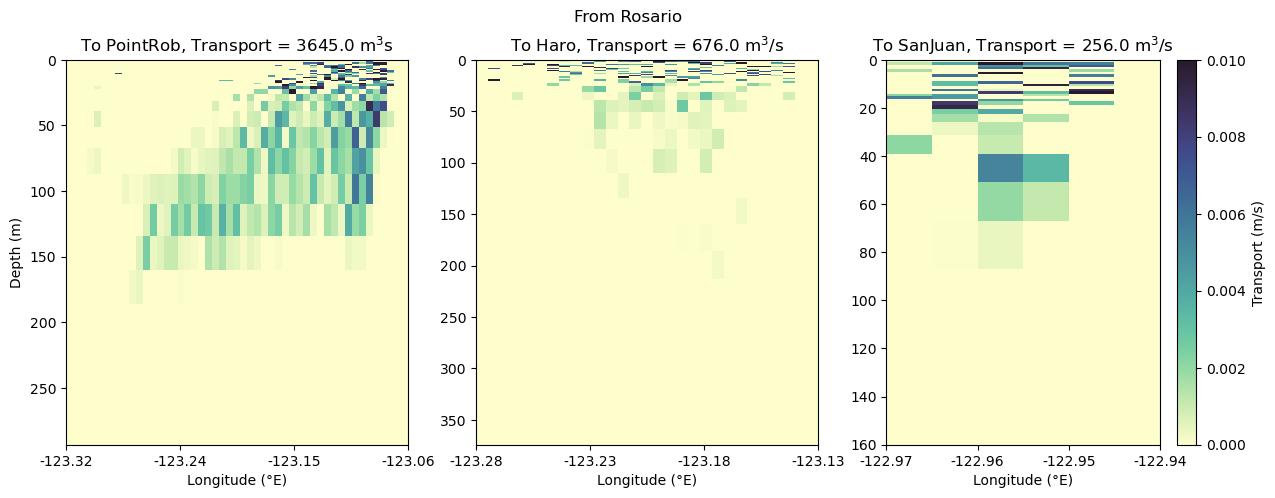

In [68]:
title = f'To PointRob, Transport = {np.round(section_transpfrspr[pointrobrs-1])} m$^3$s'
title2 = f'To Haro, Transport = {np.round(section_transpfrspr[haro-1])} m$^3$/s'
title3 = f'To SanJuan, Transport = {np.round(section_transpfrspr[sjc-1])} m$^3$/s'

vmax = 0.01

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotCS(ax1,lon_prfrspr,z_prfrspr,transp_prfrspr,lonWpr,lonEpr,35,vmax,time,title,False,True)
plotCS(ax2,lon_harofrspr,z_harofrspr,transp_harofrspr,lonWharo,lonEharo,38,vmax,time,title2,False,False)
plotCS(ax3,lon_sjcfrspr,z_sjcfrspr,transp_sjcfrspr,lonWsjc,lonEsjc,30,vmax,time,title3,True,False)
fig.suptitle('From Rosario')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Rosario - Salinity')

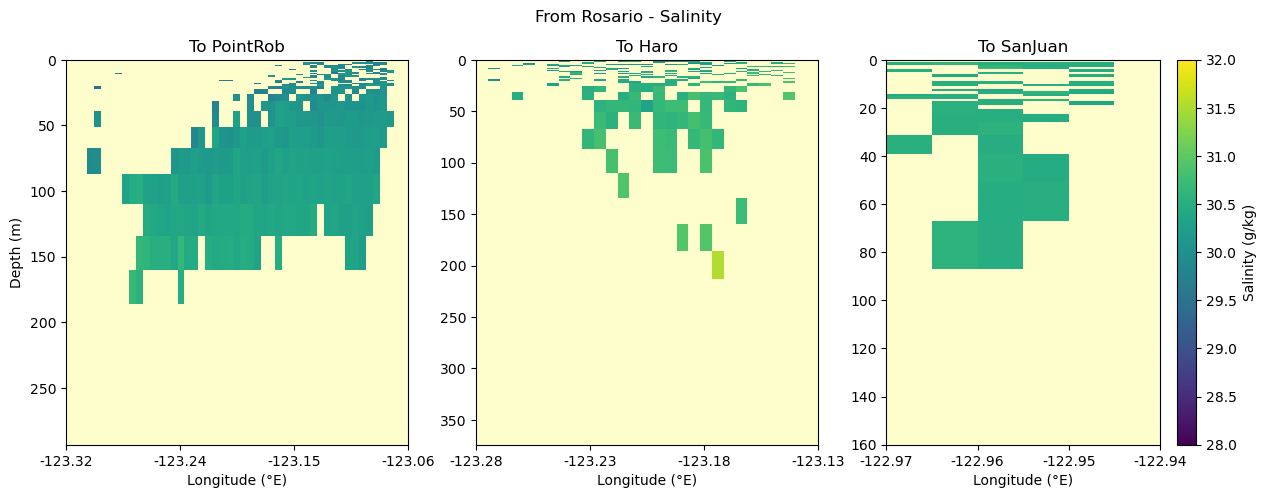

In [69]:
title = 'To PointRob'
title2 = 'To Haro'
title3 = 'To SanJuan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_prfrspr,z_prfrspr,salt_prfrspr,lonWpr,lonEpr,35,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_harofrspr,z_harofrspr,salt_harofrspr,lonWharo,lonEharo,38,time,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_sjcfrspr,z_sjcfrspr,salt_sjcfrspr,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=smin,vmax=smax)

fig.suptitle('From Rosario - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Rosario - Temperature')

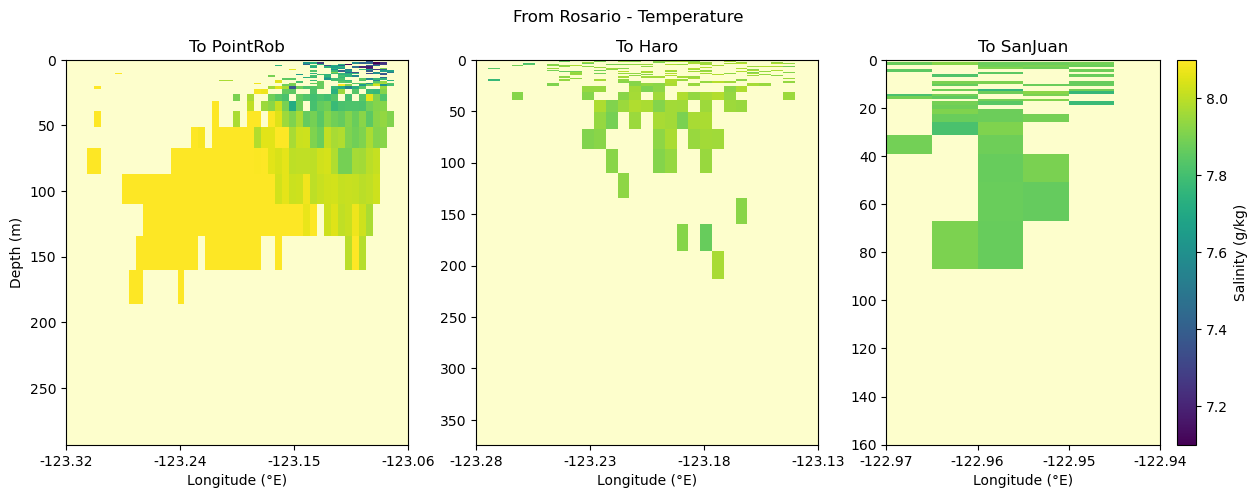

In [70]:
title = 'To PointRob'
title2 = 'To Haro'
title3 = 'To SanJuan'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_prfrspr,z_prfrspr,temp_prfrspr,lonWpr,lonEpr,35,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'sal',lon_harofrspr,z_harofrspr,temp_harofrspr,lonWharo,lonEharo,38,time,title2,False,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'sal',lon_sjcfrspr,z_sjcfrspr,temp_sjcfrspr,lonWsjc,lonEsjc,30,time,title3,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('From Rosario - Temperature')

#### Backwards - Victoria Sill

In [71]:
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbrsvs = []

vicsillrs = 4
starttime = 1
endtime = 169

sectionnumrsvs = [meander,puget,deception,vicsillrs,sjc,haro]

for section in sectionnumrsvs:
    section_transpbrsvs.append(get_datat(databrsvs,section,starttime,endtime))

section_transpbrsvs

[71040.5789502042,
 3446.4926698182494,
 1649.3030700286188,
 3178.4383147045082,
 1546.0621648128601,
 698.081556026518]

Text(0.5, 1.0, 'January')

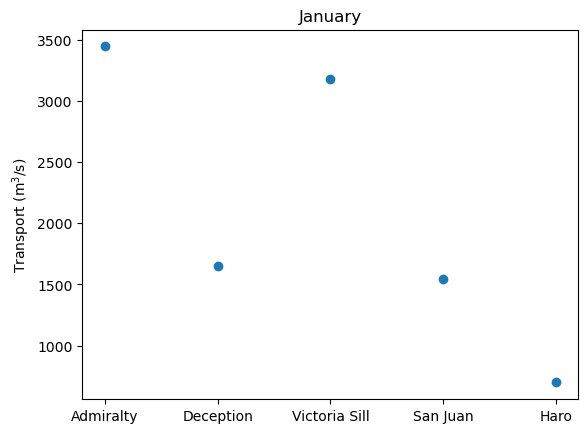

In [72]:
fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transpbrsvs[1:])
ax.set_xticks(sectionplot[1:])
ax.set_xticklabels(['Admiralty','Deception','Victoria Sill','San Juan','Haro'])
ax.set_ylabel(f'Transport (m$^3$/s)')
# ax.set_title('Backwards from Rosario (south)')
ax.set_title('January')

In [73]:
saltbrsvs,transpbrsvs,lonbrsvs,latbrsvs,depthbrsvs,sectionbrsvs,z_finalbrsvs,tempbrsvs = get_data(databrsvs)

transp_harobrsvs,lon_harobrsvs,depth_harobrsvs,z_harobrsvs,salt_harobrsvs,temp_harobrsvs = splitsec(sectionbrsvs,6,transpbrsvs,lonbrsvs,depthbrsvs,z_finalbrsvs,saltbrsvs,tempbrsvs)
transp_admbrsvs,lon_admbrsvs,depth_admbrsvs,z_admbrsvs,salt_admbrsvs,temp_admbrsvs = splitsec(sectionbrsvs,2,transpbrsvs,lonbrsvs,depthbrsvs,z_finalbrsvs,saltbrsvs,tempbrsvs)
transp_sjcbrsvs,lon_sjcbrsvs,depth_sjcbrsvs,z_sjcbrsvs,salt_sjcbrsvs,temp_sjcbrsvs = splitsec(sectionbrsvs,5,transpbrsvs,lonbrsvs,depthbrsvs,z_finalbrsvs,saltbrsvs,tempbrsvs)
transp_vsbrsvs,lon_vsbrsvs,depth_vsbrsvs,z_vsbrsvs,salt_vsbrsvs,temp_vsbrsvs  = splitsec(sectionbrsvs,4,transpbrsvs,lonbrsvs,depthbrsvs,z_finalbrsvs,saltbrsvs,tempbrsvs)
transp_decbrsvs,lon_decbrsvs,depth_decbrsvs,z_decbrsvs,salt_decbrsvs,temp_decbrsvs = splitsec(sectionbrsvs,3,transpbrsvs,lonbrsvs,depthbrsvs,z_finalbrsvs,saltbrsvs,tempbrsvs)

Text(0.5, 0.98, 'To Rosario (south)')

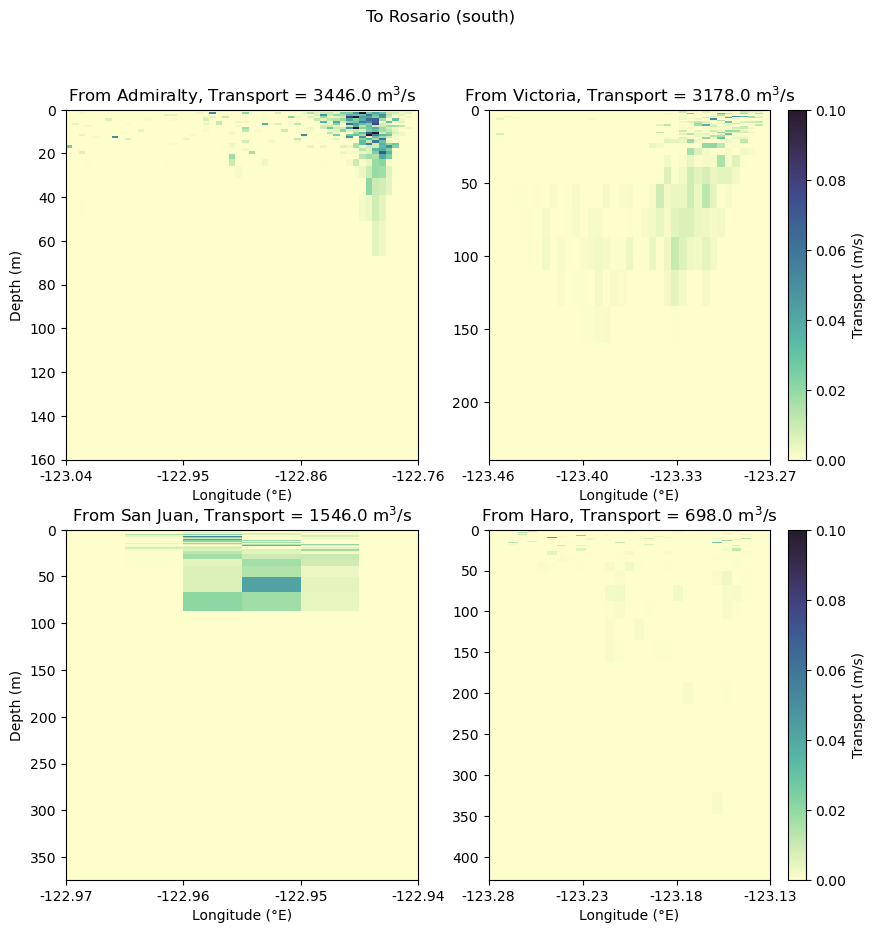

In [74]:
title = f'From San Juan, Transport = {np.round(section_transpbrsvs[sjc-1])} m$^3$/s'
title2 = f'From Admiralty, Transport = {np.round(section_transpbrsvs[puget-1])} m$^3$/s'
title3 = f'From Victoria, Transport = {np.round(section_transpbrsvs[vicsillrs-1])} m$^3$/s'
title4 = f'From Haro, Transport = {np.round(section_transpbrsvs[haro-1])} m$^3$/s'

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10))

vmax = 0.1
lonWvs = 180
lonEvs = 218
lonWdec = 330
lonEdec = 350

plotCS(ax1,lon_admbrsvs,z_admbrsvs,transp_admbrsvs,lonWadm,lonEadm,30,vmax,timeb,title2,False,True)
plotCS(ax2,lon_vsbrsvs,z_vsbrsvs,transp_vsbrsvs,180,218,33,vmax,timeb,title3,True,False)
plotCS(ax3,lon_sjcbrsvs,z_sjcbrsvs,transp_sjcbrsvs,lonWsjc,lonEsjc,38,vmax,timeb,title,False,True)
plotCS(ax4,lon_harobrsvs,z_harobrsvs,transp_harobrsvs,lonWharo,lonEharo,308,vmax,timeb,title4,True,False)
fig.suptitle('To Rosario (south)')


/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Rosario (south) - Salinity')

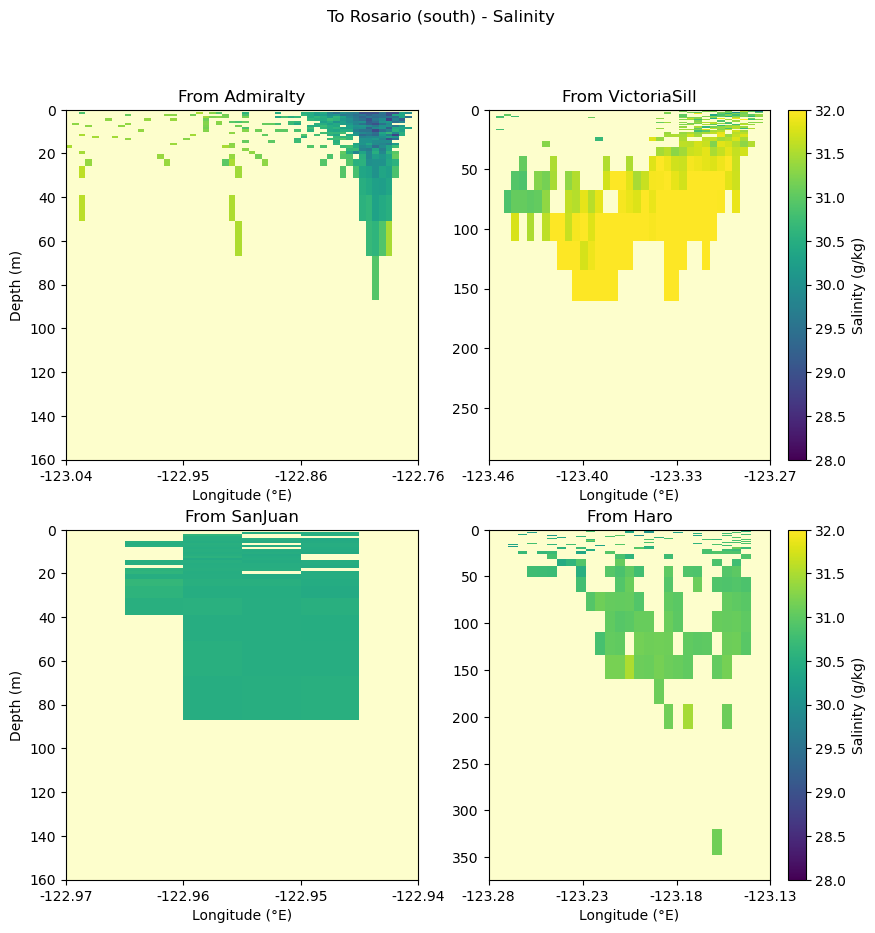

In [75]:
title = 'From Admiralty'
title2 = 'From VictoriaSill'
title3 = 'From SanJuan'
title4 = 'From Haro'

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10))

plotTS(ax1,'sal',lon_admbrsvs,z_admbrsvs,salt_admbrsvs,lonWadm,lonEadm,30,timeb,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_vsbrsvs,z_vsbrsvs,salt_vsbrsvs,lonWvs,lonEvs,35,timeb,title2,True,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_sjcbrsvs,z_sjcbrsvs,salt_sjcbrsvs,lonWsjc,lonEsjc,30,timeb,title3,False,True,vmin=smin,vmax=smax)
plotTS(ax4,'sal',lon_harobrsvs,z_harobrsvs,salt_harobrsvs,lonWharo,lonEharo,38,timeb,title4,True,False,vmin=smin,vmax=smax)

fig.suptitle('To Rosario (south) - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'To Rosario (south) - Temperature')

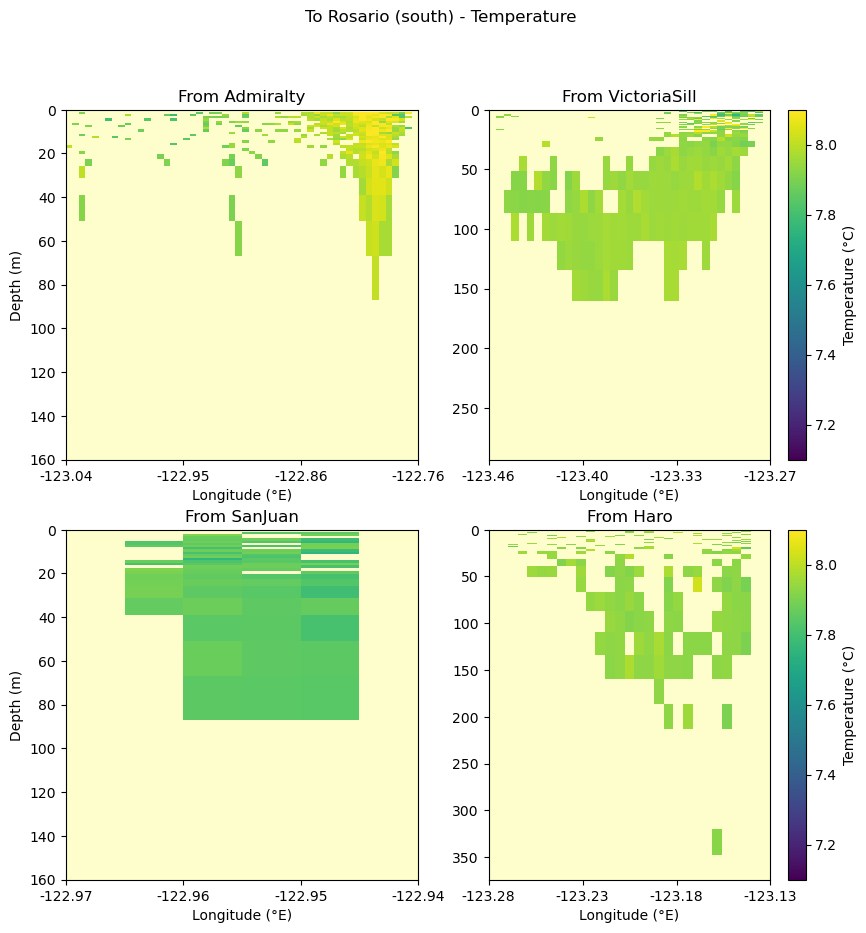

In [76]:
title = 'From Admiralty'
title2 = 'From VictoriaSill'
title3 = 'From SanJuan'
title4 = 'From Haro'

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10))

plotTS(ax1,'temp',lon_admbrsvs,z_admbrsvs,temp_admbrsvs,lonWadm,lonEadm,30,timeb,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_vsbrsvs,z_vsbrsvs,temp_vsbrsvs,lonWvs,lonEvs,35,timeb,title2,True,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',lon_sjcbrsvs,z_sjcbrsvs,temp_sjcbrsvs,lonWsjc,lonEsjc,30,timeb,title3,False,True,vmin=tmin,vmax=tmax)
plotTS(ax4,'temp',lon_harobrsvs,z_harobrsvs,temp_harobrsvs,lonWharo,lonEharo,38,timeb,title4,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('To Rosario (south) - Temperature')

In [77]:
section_transpbrsvs
section_transpbrspr

[71564.83141244487,
 115.20182191318207,
 87.41974116396953,
 3573.7568929419367,
 402.31565466217614,
 4803.9068054766585]

In [78]:
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfrsvs = []

starttime = 1
endtime = 168

for section in sectionnumrsvs:
    section_transpfrsvs.append(get_datat(datafrsvs,section,starttime,endtime))
    
section_transpfrsvs

[96486.4514619035,
 8379.074879737167,
 1169.3728419608196,
 7515.1604368091075,
 9202.730372391328,
 4497.2527246498785]

Text(0.5, 1.0, 'Rosario Seeding - Fowards (south)')

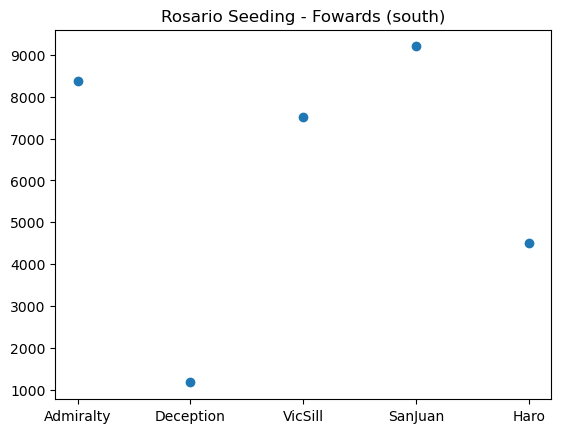

In [79]:
fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transpfrsvs[1:])
ax.set_xticks(sectionplot[1:])
ax.set_xticklabels(['Admiralty','Deception','VicSill','SanJuan','Haro'])
ax.set_title('Rosario Seeding - Fowards (south)')

In [80]:
saltfrsvs,transpfrsvs,lonfrsvs,latfrsvs,depthfrsvs,sectionfrsvs,z_finalfrsvs,tempfrsvs = get_data(datafrsvs)

#Adm,sanjuan,vicsill
transp_admfrsvs,lon_admfrsvs,depth_admfrsvs,z_admfrsvs,salt_admfrsvs,temp_admfrsvs = splitsec(sectionfrsvs,2,transpfrsvs,lonfrsvs,depthfrsvs,z_finalfrsvs,saltfrsvs,tempfrsvs)
transp_sjcfrsvs,lon_sjcfrsvs,depth_sjcfrsvs,z_sjcfrsvs,salt_sjcfrsvs,temp_sjcfrsvs = splitsec(sectionfrsvs,5,transpfrsvs,lonfrsvs,depthfrsvs,z_finalfrsvs,saltfrsvs,tempfrsvs)
transp_vsfrsvs,lon_vsfrsvs,depth_vsfrsvs,z_vsfrsvs,salt_vsfrsvs,temp_vsfrsvs = splitsec(sectionfrsvs,4,transpfrsvs,lonfrsvs,depthfrsvs,z_finalfrsvs,saltfrsvs,tempfrsvs)

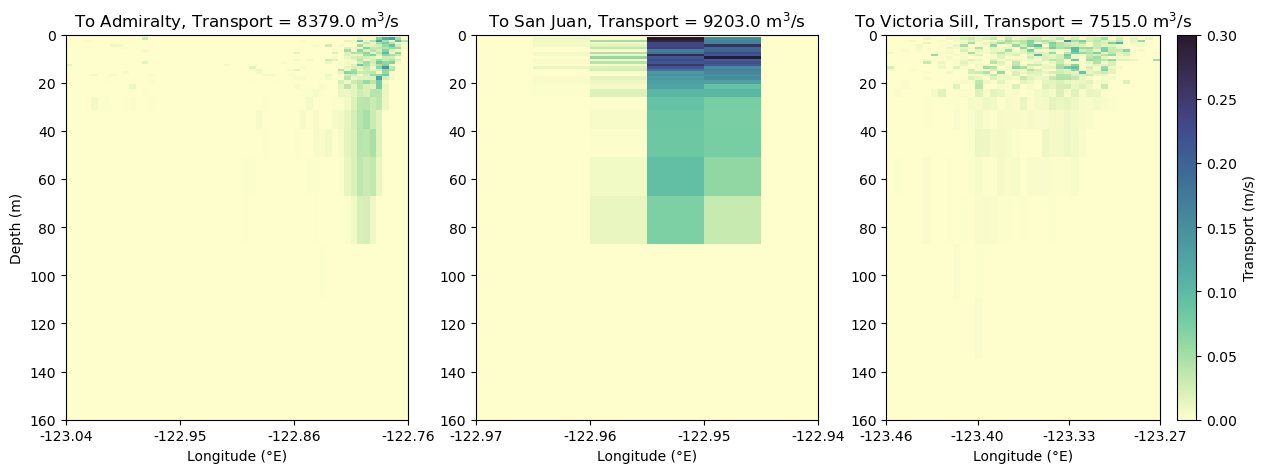

In [81]:
title = f'To Admiralty, Transport = {np.round(section_transpfrsvs[puget-1])} m$^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transpfrsvs[sjc-1])} m$^3$/s'
title3 = f'To Victoria Sill, Transport = {np.round(section_transpfrsvs[vicsillrs-1])} m$^3$/s'

vmax = 0.3

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotCS(ax1,lon_admfrsvs,z_admfrsvs,transp_admfrsvs,lonWadm,lonEadm,30,vmax,time,title,False,True)
plotCS(ax2,lon_sjcfrsvs,z_sjcfrsvs,transp_sjcfrsvs,lonWsjc,lonEsjc,30,vmax,time,title2,False,False)
plotCS(ax3,lon_vsfrsvs,z_vsfrsvs,transp_vsfrsvs,lonWvs,lonEvs,30,vmax,time,title3,True,False)

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Rosario - Salinity')

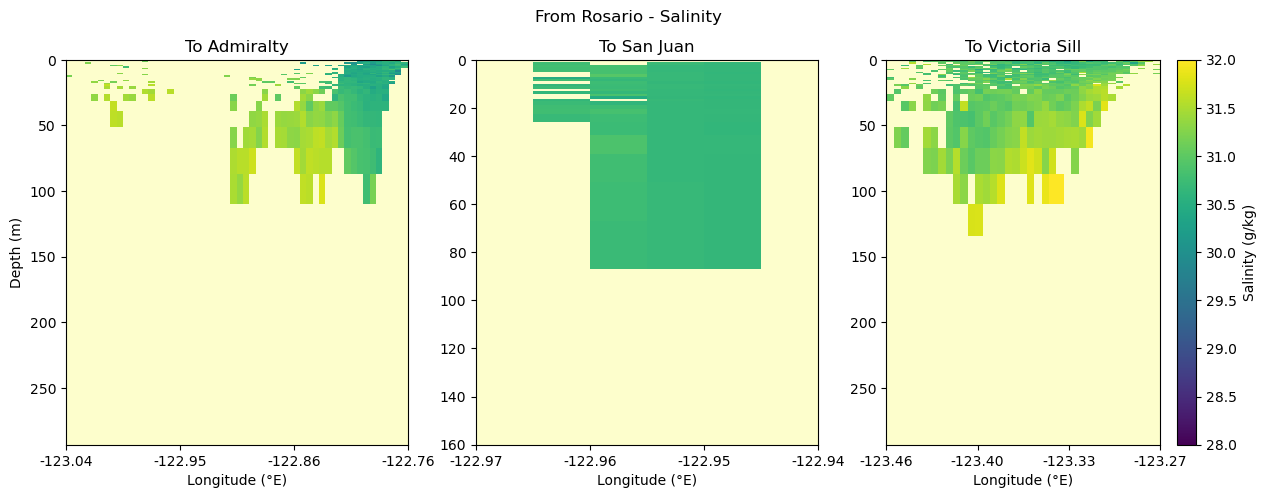

In [82]:
title = 'To Admiralty'
title2 = 'To San Juan'
title3 = 'To Victoria Sill'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',lon_admfrsvs,z_admfrsvs,salt_admfrsvs,lonWadm,lonEadm,35,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',lon_sjcfrsvs,z_sjcfrsvs,salt_sjcfrsvs,lonWsjc,lonEsjc,30,time,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',lon_vsfrsvs,z_vsfrsvs,salt_vsfrsvs,lonWvs,lonEvs,35,time,title3,True,False,vmin=smin,vmax=smax)

fig.suptitle('From Rosario - Salinity')

/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Rosario - Temperature')

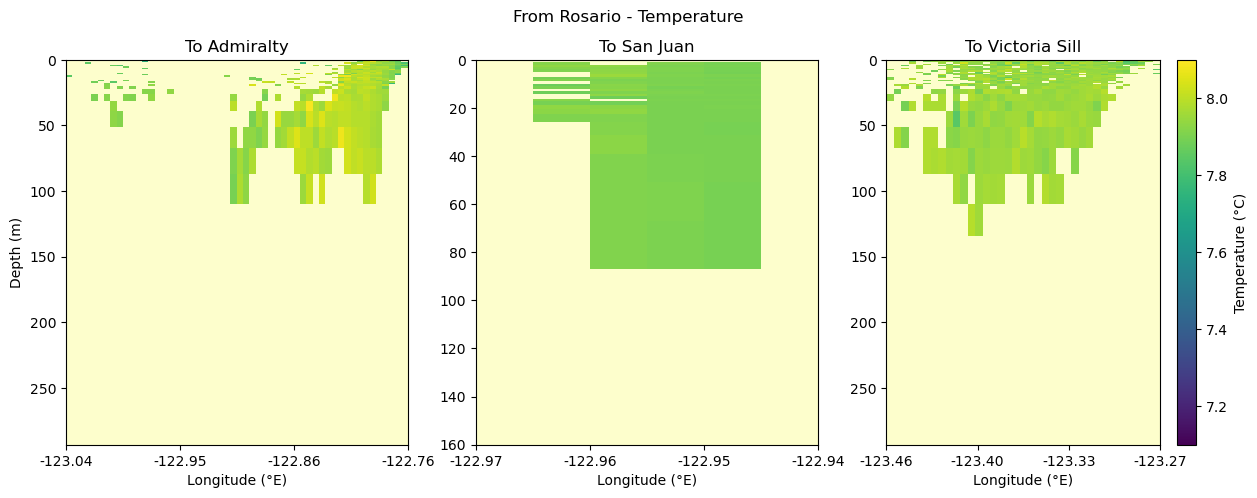

In [83]:
title = 'To Admiralty'
title2 = 'To San Juan'
title3 = 'To Victoria Sill'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',lon_admfrsvs,z_admfrsvs,temp_admfrsvs,lonWadm,lonEadm,35,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',lon_sjcfrsvs,z_sjcfrsvs,temp_sjcfrsvs,lonWsjc,lonEsjc,30,time,title2,False,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',lon_vsfrsvs,z_vsfrsvs,temp_vsfrsvs,lonWvs,lonEvs,35,time,title3,True,False,vmin=tmin,vmax=tmax)

fig.suptitle('From Rosario - Temperature')

#### Comparison Rosario to/from Admiralty

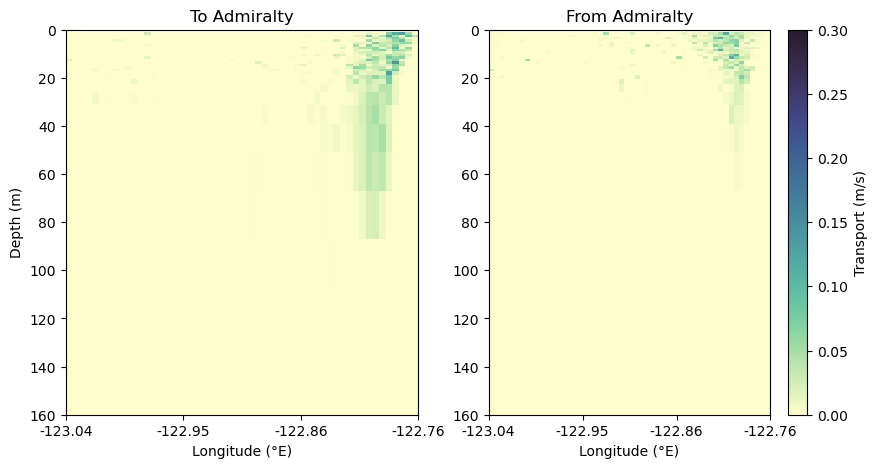

In [84]:
title = 'To Admiralty'
title2 = 'From Admiralty'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_admfrsvs,z_admfrsvs,transp_admfrsvs,lonWadm,lonEadm,30,vmax,time,title,False,True)
plotCS(ax2,lon_admbrsvs,z_admbrsvs,transp_admbrsvs,lonWadm,lonEadm,30,vmax,timeb,title2,True,False)


### Admiralty Backward Seeding

In [85]:
databackadm = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

vicsill_as = 2
admirality_as = 1

sectionnumas = [meander,vicsill_as,deception,rosario,sjc,haro]

section_transpbas = []

starttime = 1
endtime = 169

for section in sectionnumas:
    section_transpbas.append(get_datat(databackadm,section,starttime,endtime))
    
    
section_transpbas

[68936.20918527979,
 27930.424539421707,
 17.040374901414026,
 3465.8609497435,
 658.9286119134612,
 1202.3808905111837]

### Admiralty - Forward Seeding

In [86]:
datafadm = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfas = []

starttime = 1
endtime = 168

for section in sectionnumas:
    section_transpfas.append(get_datat(datafadm,section,starttime,endtime))
    
section_transpfas

[101992.0359021202,
 31376.8941213031,
 13.456059159455611,
 2470.603053432186,
 1859.0735586814149,
 10600.026475230792]

In [87]:
saltfas,transpfas,lonfas,latfas,depthfas,sectionfas,z_finalfas,tempfas = get_data(datafadm)

transp_rosfas,lon_rosfas,depth_rosfas,z_rosfas,salt_rosfas,temp_rasfas = splitsec(sectionfas,4,transpfas,lonfas,depthfas,z_finalfas,saltfas,tempfas)

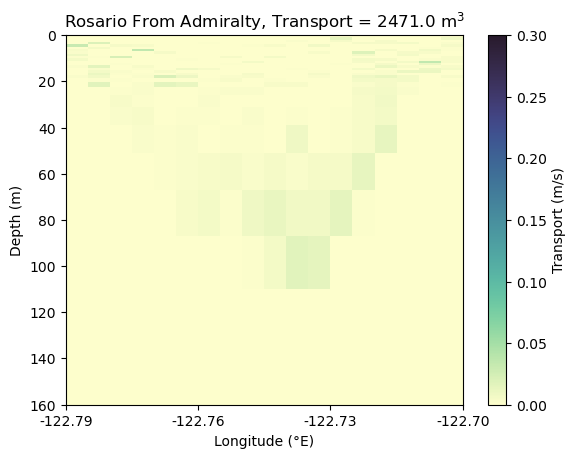

In [88]:
title = f'Rosario From Admiralty, Transport = {np.round(section_transpfas[rosario-1])} m$^3$'

fig,ax = plt.subplots()

plotCS(ax,lon_rosfas,z_rosfas,transp_rosfas,lonWros,lonEros,30,vmax,time,title,True,True)


### Victoria Sill - Backwards

In [89]:
databackvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbvs = []

for section in sectionnum:
    section_transpbvs.append(get_datat(databackvs,section,starttime,endtime))
    
section_transpbvs

[409179.6307677012,
 12992.33201901176,
 47.51765128834822,
 2594.552625900211,
 4117.771644444456,
 50438.16720159346]

### Haro Seeding - Backwards Victoria Sill

In [90]:
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbhsvs = []

vicsill_hs = 6

sectionnumhsvs = [meander,puget,deception,rosario,sjc,vicsill_hs]

starttime = 1
endtime = 169

for section in sectionnumhsvs:
    section_transpbhsvs.append(get_datat(databhsvs,section,starttime,endtime))
    
section_transpbhsvs

[226881.99527235673,
 11133.706466836733,
 9.075665726383574,
 3678.625408075249,
 7762.132881284261,
 29846.392749580074]

### Haro Seeding - Forwards Victoria Sill

In [91]:
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfhsvs = []

starttime = 1
endtime = 168

for section in sectionnumhsvs:
    section_transpfhsvs.append(get_datat(datafhsvs,section,starttime,endtime))
    
section_transpfhsvs

[343860.4397453345,
 2790.954554565364,
 29.80699536525302,
 4488.857020480348,
 3864.205239228805,
 72712.01022361014]

### SanJuan Seeding - Backwards Victoria Sill

In [92]:
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbsjvs = []
vicsill_sjcs = 5

sectionnumsjcvs = [meander,puget,deception,rosario,vicsill_sjcs,haro]

starttime = 1
endtime = 169

for section in sectionnumsjcvs:
    section_transpbsjvs.append(get_datat(databsjvs,section,starttime,endtime))
    
section_transpbsjvs

[17964.35505709034,
 4569.108082963765,
 122.12949119427348,
 5818.826166683787,
 2533.4872800859903,
 560.1672308134767]

### San Juan Channel - Forwards Victoria Sill

In [93]:
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfsjvs = []

starttime = 1
endtime = 168

for section in sectionnumsjcvs:
    section_transpfsjvs.append(get_datat(datafsjvs,section,starttime,endtime))
    
section_transpfsjvs

[22316.74551376587,
 1895.1250958068097,
 49.696032858719285,
 3560.4112974008535,
 3912.377249077431,
 9230.688058125956]

In [94]:
saltfsjvs,transpfsjvs,lonfsjvs,latfsjvs,depthfsjvs,sectionfsjvs,z_finalfsjvs,tempfsjvs = get_data(datafsjvs)

transp_rosfsjvs,lon_rosfsjvs,depth_rosfsjvs,z_rosfsjvs,salt_rosfsjvs,temp_rasfsjvs = splitsec(sectionfsjvs,4,transpfsjvs,lonfsjvs,depthfsjvs,z_finalfsjvs,saltfsjvs,tempfsjvs)

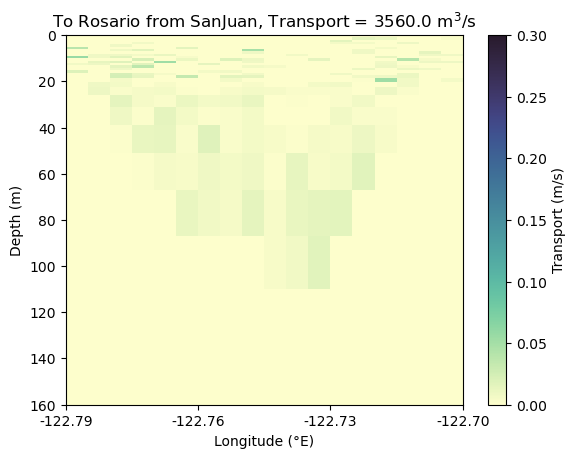

In [95]:
title = f'To Rosario from SanJuan, Transport = {np.round(section_transpfsjvs[rosario-1])} m$^3$/s'

fig,ax = plt.subplots()

plotCS(ax,lon_rosfsjvs,z_rosfsjvs,transp_rosfsjvs,lonWros,lonEros,30,vmax,time,title,True,True)

### Backwards Victoria Sill (start 01/01)

In [96]:
databvs2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbvs2 = []

starttime = 1
endtime = 169

for section in sectionnum:
    section_transpbvs2.append(get_datat(databvs2,section,starttime,endtime))
    
section_transpbvs2

[387097.8826899624,
 32943.372249205,
 346.29274011273395,
 16564.384974535627,
 11237.732468507262,
 58334.84352414376]

### Backwards Haro Seeding - 01/01

In [97]:
databhsvs2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbhsvs2 = []

starttime = 1
endtime = 169

for section in sectionnumhs:
    section_transpbhsvs2.append(get_datat(databhsvs2,section,starttime,endtime))
    
section_transpbhsvs2

[250120.21707170524,
 2608.044077785802,
 87.76024746776923,
 2399.2277140782217,
 3915.9321859038914,
 74455.66401152442]

### Backwards Rosario Seeding VS Sill - 01/01

In [98]:
databrsvs2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbrsvs2 = []

starttime = 1
endtime = 169

for section in sectionnumrs:
    section_transpbrsvs2.append(get_datat(databrsvs2,section,starttime,endtime))
    
section_transpbrsvs2

[69878.50222595931,
 758.7235084713933,
 894.9823108881565,
 7052.780736027733,
 937.6839871274766,
 1509.6079044687995]

### Backwards San Juan Seeding VS Sill - 01/01

In [99]:
databsjvs2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbsjvs2 = []

starttime = 1
endtime = 169

for section in sectionnumsjcvs:
    section_transpbsjvs2.append(get_datat(databsjvs2,section,starttime,endtime))
    
section_transpbsjvs2

[17388.144041553678,
 583.830332428229,
 153.89195130915272,
 7407.682469112916,
 3705.980422829994,
 2324.775070538904]

### Backwards Admiralty - 01/01

In [100]:
databadm2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbas2 = []

starttime = 1
endtime = 169

for section in sectionnumas:
    section_transpbas2.append(get_datat(databadm2,section,starttime,endtime))
    
section_transpbas2

[78642.400124489,
 26381.046698610524,
 192.3006006474474,
 7730.103123255853,
 745.676616389838,
 1178.8168309689001]

### Forwards Deception Seeding

In [101]:
datafdec = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfds = []

starttime = 1
endtime = 168

vicsill_ds = 3

sectionnumds = [meander,puget,vicsill_ds,rosario,sjc,haro]

for section in sectionnumds:
    section_transpfds.append(get_datat(datafdec,section,starttime,endtime))
    
section_transpfds

[879.6556309120681,
 243.72129138523624,
 161.0445662651635,
 1148.4336415267323,
 317.8958860254692,
 165.41851334799676]

### Backwards Deception Seeding

In [102]:
databdec = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbds = []

starttime = 1
endtime = 168

for section in sectionnumds:
    section_transpbds.append(get_datat(databdec,section,starttime,endtime))
    
section_transpbds

[802.0567120448683,
 141.92548175611907,
 313.416845793304,
 865.0322838396635,
 380.49333965260604,
 204.81530050696216]

76335.49015953543
29846.392749580074
5921.754855595813
3178.4383147045082


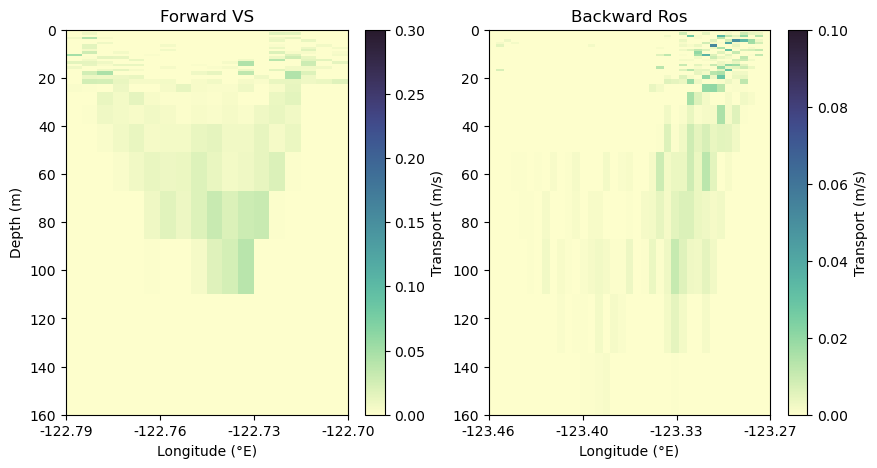

In [103]:
#Compare fvs and brsvs

print(section_trans[haro-1])
print(section_transpbhsvs[haro-1])

print(section_trans[rosario-1])
print(section_transpbrsvs[rosario-1])

title = 'Forward VS'
title2 = 'Backward Ros'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,lon_ros,z_ros,transp_ros,lonWros,lonEros,30,vmax,time,title,True,True)
plotCS(ax2,lon_vsbrsvs,z_vsbrsvs,transp_vsbrsvs,lonWvs,lonEvs,30,0.1,timeb,title2,True,False)

### PR Side Balance

In [104]:
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbhspr = []

pointrobhs = 6

sectionnumhspr = [meander,gulf1,gulf2,rosario,sjc,pointrobhs]

starttime = 1
endtime = 169

for section in sectionnumhspr:
    section_transpbhspr.append(get_datat(databhspr,section,starttime,endtime))
    
section_transpbhspr

[277186.97915954934,
 7982.657356015036,
 3163.992576821039,
 176.49253319972917,
 369.9196054049685,
 18414.627936597088]

In [105]:
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfsjpr = []

pointrobsj = 5

sectionnumsj = [meander,gulf1,gulf2,rosario,pointrobsj,haro]

starttime = 1
endtime = 168

for section in sectionnumsj:
    section_transpfsjpr.append(get_datat(datafsjpr,section,starttime,endtime))
    
section_transpfsjpr

[35061.02406966028,
 84.03948171381677,
 25.92772051248601,
 1204.0714894056398,
 1574.1470494113084,
 2662.264276628435]

In [106]:
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbsjpr = []

starttime = 1
endtime = 169

for section in sectionnumsj:
    section_transpbsjpr.append(get_datat(databsjpr,section,starttime,endtime))
    
section_transpbsjpr

[28932.43041738503,
 146.22745943139773,
 41.51625905581615,
 34.57698459993016,
 2099.4314220522974,
 3614.4346861172367]

In [107]:
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfg1 = []

starttime = 1
endtime = 168

pointrobg1 = 2

sectionnumg1s = [meander,pointrobg1,gulf2,rosario,sjc,haro]

for section in sectionnumg1s:
    section_transpfg1.append(get_datat(datafg1,section,starttime,endtime))
    
section_transpfg1

[12414.520521955463,
 2055.4146096793766,
 1175.676640364196,
 223.35337668676806,
 147.2731511197059,
 7092.346910979786]

In [108]:
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbg1 = []

starttime = 1
endtime = 168

for section in sectionnumg1s:
    section_transpbg1.append(get_datat(databg1,section,starttime,endtime))
    
section_transpbg1

[11350.735618945831,
 1820.1461659282727,
 400.59119592480135,
 200.02267788796695,
 141.70747065882802,
 7497.4386971339945]

In [109]:
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpfg2 = []

starttime = 1
endtime = 168

pointrobg2 = 3

sectionnumg2s = [meander,gulf1,pointrobg2,rosario,sjc,haro]

for section in sectionnumg2s:
    section_transpfg2.append(get_datat(datafg2,section,starttime,endtime))
    
section_transpfg2

[13711.097806154406,
 48.24608587891079,
 261.3082263335752,
 39.71892922151951,
 39.98299861679655,
 3441.4309309955556]

In [110]:
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

section_transpbg2 = []

starttime = 1
endtime = 168

for section in sectionnumg2s:
    section_transpbg2.append(get_datat(databg2,section,starttime,endtime))
    
section_transpbg2

[11754.382140991369,
 44.39610789215433,
 104.81533391623113,
 23.799290061750103,
 14.481223348030714,
 1790.1938161195324]

### Comparison (Rosario backward seeding 01/01 vs. 01/28)

In [111]:
databrsvs3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_feb18/back_straight_28feb18_s7t28/ariane_positions_quantitative.nc')

section_transpbrsvs3 = []

starttime = 1
endtime = 169

for section in sectionnumrs:
    section_transpbrsvs3.append(get_datat(databrsvs3,section,starttime,endtime))
    
section_transpbrsvs3

[73354.43837583093,
 739.7669885042703,
 952.6324470058784,
 6896.159115111249,
 1182.676700995915,
 1375.8742036004348]

In [112]:
print('01/01')
print('From Admiralty:',section_transpbrsvs2[1])
print('From VSill:',section_transpbrsvs2[3])
print('From SanJuan:',section_transpbrsvs2[4])
print('From Haro:',section_transpbrsvs2[5],'\n')

print('01/28')
print('From Admiralty:',section_transpbrsvs[1])
print('From VSill:',section_transpbrsvs[3])
print('From SanJuan:',section_transpbrsvs[4])
print('From Haro:',section_transpbrsvs[5],'\n')

print('02/28')
print('From Admiralty:',section_transpbrsvs3[1])
print('From VSill:',section_transpbrsvs3[3])
print('From SanJuan:',section_transpbrsvs3[4])
print('From Haro:',section_transpbrsvs3[5],'\n')


01/01
From Admiralty: 758.7235084713933
From VSill: 7052.780736027733
From SanJuan: 937.6839871274766
From Haro: 1509.6079044687995 

01/28
From Admiralty: 3446.4926698182494
From VSill: 3178.4383147045082
From SanJuan: 1546.0621648128601
From Haro: 698.081556026518 

02/28
From Admiralty: 739.7669885042703
From VSill: 6896.159115111249
From SanJuan: 1182.676700995915
From Haro: 1375.8742036004348 



# July 2018

#### Forwards Victoria Sill

In [115]:
datafvs_07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transp07 = []

starttime = 1
endtime = 168

for section in sectionnum:
    section_transp07.append(get_datat(datafvs_07,section,starttime,endtime))

section_transp07

[327423.05634853523,
 24441.672291564882,
 54.550467757819334,
 10726.563483746011,
 4122.464553658308,
 104444.18031333659]

#### Forwards Admiralty

In [116]:
datafas_07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfas07 = []

for section in sectionnumas:
    section_transpfas07.append(get_datat(datafas_07,section,starttime,endtime))
    
section_transpfas07

[70448.14095020594,
 35594.418277119585,
 3.5520096032090502,
 968.2886658622959,
 234.08990196411378,
 2207.0252971384416]

#### Forwards Deception

In [117]:
datafds_07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfds07 = []

for section in sectionnumds:
    section_transpfds07.append(get_datat(datafds_07,section,starttime,endtime))
    
section_transpfds07

[790.383944891621,
 362.9272868007818,
 482.09363423596994,
 618.8064655939168,
 4.573228619055943,
 2.516096558788989]

#### Forwards Rosario

In [118]:
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfrsvs07 = []

for section in sectionnumrs:
    section_transpfrsvs07.append(get_datat(datafrsvs07,section,starttime,endtime))
    
section_transpfrsvs07

[49308.56003357121,
 11845.12375736106,
 663.9223926567278,
 34832.572233340834,
 5285.286100966774,
 2514.5576578339324]

#### Forwards San Juan

In [119]:
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfsjvs07 = []

for section in sectionnumsj:
    section_transpfsjvs07.append(get_datat(datafsjvs07,section,starttime,endtime))
    
section_transpfsjvs07

[12848.746333935505,
 704.9310489299469,
 15.139992958795032,
 1230.762861538577,
 12730.606649093505,
 6808.165990144776]

#### Forwards Haro

In [120]:
datafhsvs07 =xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfhsvs07 = []

for section in sectionnumhs:
    section_transpfhsvs07.append(get_datat(datafhsvs07,section,starttime,endtime))
    
section_transpfhsvs07

[193895.55558626397,
 976.7640242531925,
 13.360030458319377,
 1368.3865224789406,
 2132.4087963416055,
 78103.49033463027]

## Point Roberts Section

#### Fowards point roberts 

In [122]:
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpr07 =[]

starttime = 1 
endtime = 168
print(sectionnumback)

for section in sectionnumback:
    section_transpr07.append(get_datat(datafpr07,section,starttime,endtime))
    
section_transpr07

[0, 2, 3, 4, 5, 6]


[201282.89211733933,
 5576.8270091205995,
 608.2917527383669,
 18359.050295421643,
 4533.682783453062,
 26213.777579208105]

In [123]:
saltfpr07,transpfpr07,lonfpr07,latfpr07,depthfpr07,sectionfpr07,z_finalfpr07,tempfpr07 = get_data(datafpr07)

#Adm,sanjuan,vicsill
transp_rosfpr07,lon_rosfpr07,depth_rosfpr07,z_rosfpr07,salt_rosfpr07,temp_rosfpr07 = splitsec(sectionfpr07,4,transpfpr07,lonfpr07,depthfpr07,z_finalfpr07,saltfpr07,tempfpr07)
transp_sjcfpr07,lon_sjcfpr07,depth_sjcfpr07,z_sjcfpr07,salt_sjcfpr07,temp_sjcfpr07 = splitsec(sectionfpr07,5,transpfpr07,lonfpr07,depthfpr07,z_finalfpr07,saltfpr07,tempfpr07)

#### Forwards Rosario

In [124]:
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfrspr07 = []

for section in sectionnumrs:
    section_transpfrspr07.append(get_datat(datafrspr07,section,starttime,endtime))
    
section_transpfrspr07

[68304.77260855194,
 0.0,
 2.769320636431659,
 166.77373925559817,
 28.915749107390223,
 71.94051073263275]

#### Forward Haro

In [125]:
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfhspr07 = []

for section in sectionnumhs:
    section_transpfhspr07.append(get_datat(datafhspr07,section,starttime,endtime))
    
section_transpfhspr07

[240704.5777814997,
 3037.2355590603133,
 1172.3410509509924,
 11147.500617638749,
 6114.588642992972,
 52078.326153363676]

#### Forward San Juan

In [126]:
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfsjpr07 = []

for section in sectionnumsj:
    section_transpfsjpr07.append(get_datat(datafsjpr07,section,starttime,endtime))
    
section_transpfsjpr07

[23786.484473451634,
 30.121237751008938,
 5.450240200586923,
 1500.5178006174979,
 537.0571359168848,
 892.6423461629017]

#### Forward Gulf1

In [127]:
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfg107 = []

for section in sectionnumg1s:
    section_transpfg107.append(get_datat(datafg107,section,starttime,endtime))
    
section_transpfg107

[11823.14853499771,
 1445.5304507408005,
 313.7525794397821,
 187.90718829683482,
 121.11107311477294,
 7534.234784563366]

#### Forward Gulf2

In [128]:
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpfg207 = []

for section in sectionnumg2s:
    section_transpfg207.append(get_datat(datafg207,section,starttime,endtime))
    
section_transpfg207

[9272.584216398076,
 90.04234583242561,
 139.780956312566,
 54.175130231269726,
 43.83513905779042,
 3059.5778427900327]

### Backwards Rosario Seeding - July 2018

In [130]:
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbrspr07 = []

starttime = 1
endtime = 169

for section in sectionnumrs:
    section_transpbrspr07.append(get_datat(databrspr07,section,starttime,endtime))
    
section_transpbrspr07

[73412.30762111096,
 239.31455531654578,
 34.01324971564424,
 17649.557195403664,
 1638.7802848402625,
 15743.908564368823]

In [131]:
saltbrspr07,transpbrspr07,lonbrspr07,latbrspr07,depthbrspr07,sectionbrspr07,z_finalbrspr07,tempbrspr07 = get_data(databrspr07)

transp_harobrspr07,lon_harobrspr07,depth_harobrspr07,z_harobrspr07,salt_harobrspr07,temp_harobrspr07 = splitsec(sectionbrspr07,6,transpbrspr07,lonbrspr07,depthbrspr07,z_finalbrspr07,saltbrspr07,tempbrspr07)
transp_sjcbrspr07,lon_sjcbrspr07,depth_sjcbrspr07,z_sjcbrspr07,salt_sjcbrspr07,temp_sjcbrspr07 = splitsec(sectionbrspr07,5,transpbrspr07,lonbrspr07,depthbrspr07,z_finalbrspr07,saltbrspr07,tempbrspr07)
transp_prbrspr07,lon_prbrspr07,depth_prbrspr07,z_prbrspr07,salt_prbrspr07,temp_prbrspr07 = splitsec(sectionbrspr07,4,transpbrspr07,lonbrspr07,depthbrspr07,z_finalbrspr07,saltbrspr07,tempbrspr07)

Text(0.5, 1.0, 'July')

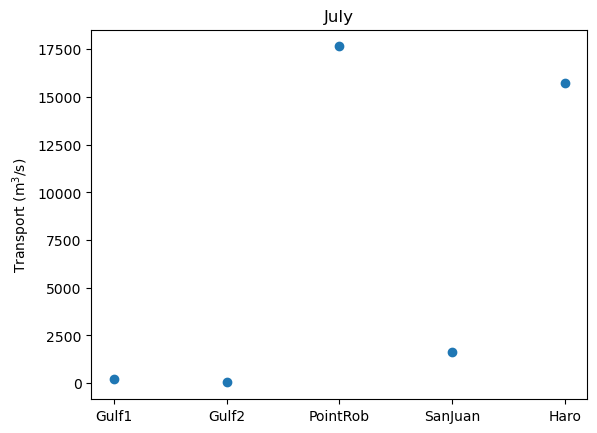

In [132]:
fig,ax = plt.subplots()

ax.scatter(sectionplot[1:],section_transpbrspr07[1:])
ax.set_xticks(sectionplot[1:])
ax.set_xticklabels(['Gulf1','Gulf2','PointRob','SanJuan','Haro'])
ax.set_ylabel('Transport (m$^3$/s)')
ax.set_title('July')

### Backwards Rosario Seeding - South July 2018

In [133]:
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbrsvs07 = []

starttime = 1
endtime = 169

for section in sectionnumrs:
    section_transpbrsvs07.append(get_datat(databrsvs07,section,starttime,endtime))
    
section_transpbrsvs07



[59175.24445066563,
 1578.6619803841445,
 639.397265043908,
 11428.121279693707,
 1480.042858603816,
 2160.4777334030864]

Text(0.5, 1.0, 'July')

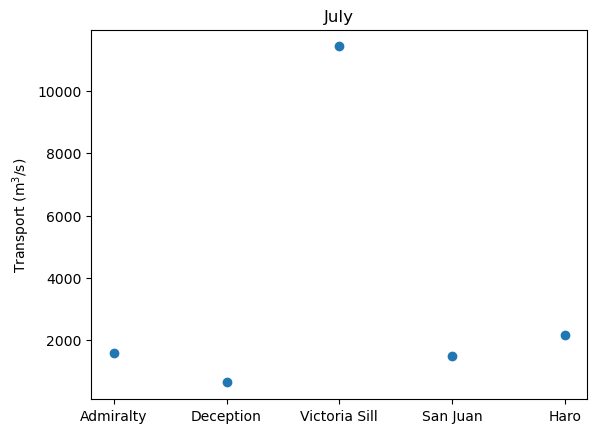

In [134]:
fig,ax = plt.subplots()

ax.scatter(sectionnum[1:],section_transpbrsvs07[1:])
ax.set_xticks(sectionnum[1:])
ax.set_xticklabels(['Admiralty','Deception','Victoria Sill','San Juan','Haro'])
ax.set_ylabel(f'Transport (m$^3$/s)')
ax.set_title('July')

### Backwards Point Roberts Seeding - July 2018

In [135]:
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbpr07 = []

starttime = 1
endtime = 169

for section in sectionnumback:
    section_transpbpr07.append(get_datat(databpr07,section,starttime,endtime))
    
section_transpbpr07

[247666.9241114652,
 1324.3628732502425,
 61.54436751767122,
 436.05256794446785,
 654.9001697091772,
 45325.29351631329]

In [136]:
saltbpr07,transpbpr07,lonbpr07,latbpr07,depthbpr07,sectionbpr07,z_finalbpr07,tempbpr07 = get_data(databpr07)

transp_rosbpr07,lon_rosbpr07,depth_rosbpr07,z_rosbpr07,salt_rosbpr07,temp_rosbpr07 = splitsec(sectionbpr07,4,transpbpr07,lonbpr07,depthbpr07,z_finalbpr07,saltbpr07,tempbpr07)


### Backwards SJC seeding (PR)

In [137]:
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbsjpr07 = []

starttime = 1
endtime = 169

for section in sectionnumsj:
    section_transpbsjpr07.append(get_datat(databsjpr07,section,starttime,endtime))
    
section_transpbsjpr07

[25997.775985385964,
 117.31100086536092,
 13.629882744404092,
 108.43530901034119,
 5509.190963399455,
 7243.55052943054]

### Backwards Gulf1 seeding 

In [138]:
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbg107 = []

starttime = 1
endtime = 168

for section in sectionnumg1s:
    section_transpbg107.append(get_datat(databg107,section,starttime,endtime))
    
section_transpbg107

[11823.14853499771,
 1445.5304507408005,
 313.7525794397821,
 187.90718829683482,
 121.11107311477294,
 7534.234784563366]

### Backwards Gulf2 seeding

In [139]:
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbg207 = []

for section in sectionnumg1s:
    section_transpbg207.append(get_datat(databg207,section,starttime,endtime))
    
section_transpbg207

[9272.584216398076,
 90.04234583242561,
 139.780956312566,
 54.175130231269726,
 43.83513905779042,
 3059.5778427900327]

### Backwards haro seeding (PR) - July

In [140]:
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

section_transpbhspr07 = []

for section in sectionnumhs:
    section_transpbhspr07.append(get_datat(databhspr07,section,starttime,endtime))
    
section_transpbhspr07

[314656.2380351598,
 8183.561765207636,
 3724.438925943128,
 260.1220001710418,
 977.9549519063314,
 21532.064314239626]

In [141]:
np.sum([section_transpbg107[3],section_transpbpr07[3],section_transpbhspr07[3],section_transpbsjpr07[3],section_transpbg207[3]])

1046.6921956539554

### January / July Comparison

### Plots for committee meeting 

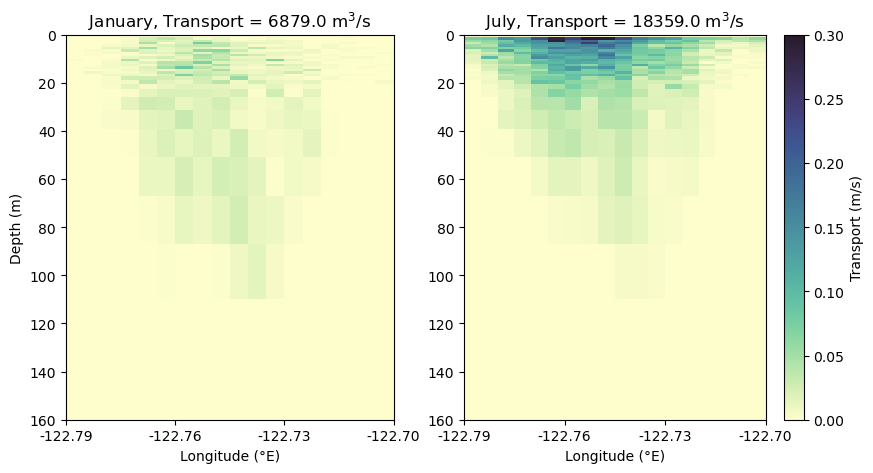

In [142]:
title1 = f'January, Transport = {np.round(section_transpr[rosario-1])} m$^3$/s'
title2 = f'July, Transport = {np.round(section_transpr07[rosario-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.15]})

plotCS(ax1,lon_rospr,z_rospr,transp_rospr,lonWros,lonEros,30,vmax,time,title1,False,True)
plotCS(ax2,lon_rosfpr07,z_rosfpr07,transp_rosfpr07,lonWros,lonEros,30,vmax,time,title2,True,False)


/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_22602/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


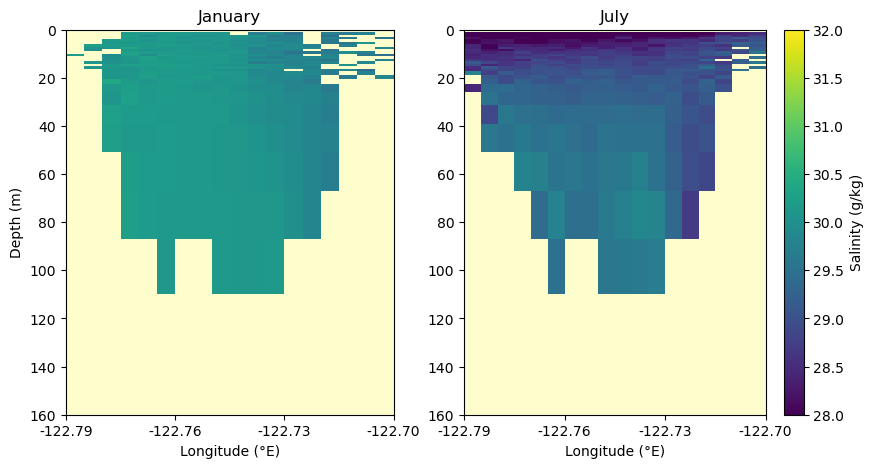

In [143]:
title1 = 'January'
title2 = 'July'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.15]})

plotTS(ax1,'sal',lon_rospr,z_rospr,salt_rospr,lonWros,lonEros,30,time,title1,False,True,vmax=smax,vmin=smin)
plotTS(ax2,'sal',lon_rosfpr07,z_rosfpr07,salt_rosfpr07,lonWros,lonEros,30,time,title2,True,False,vmax=smax,vmin=smin)

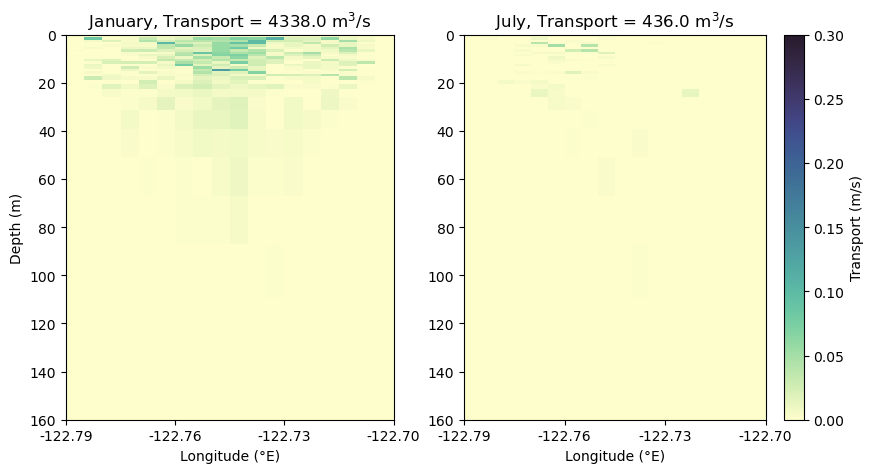

In [144]:
title1 = f'January, Transport = {np.round(section_transb4[rosario-1])} m$^3$/s'
title2 = f'July, Transport = {np.round(section_transpbpr07[rosario-1])} m$^3$/s'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.15]})

plotCS(ax1,lon_rosb4,z_rosb4,transp_rosb4,lonWros,lonEros,30,vmax,time,title1,False,True)
plotCS(ax2,lon_rosbpr07,z_rosbpr07,transp_rosbpr07,lonWros,lonEros,30,vmax,time,title2,True,False)

In [145]:
np.sum(section_transpbrspr07[1:])

35305.57384964494